Induction Head Analysis Framework
===================================
This notebook provides tools for identifying and analyzing induction heads
across multiple transformer models using TransformerLens.

Features:
1. Multi-model comparison (GPT-2 variants, etc.)
2. Multi-language input examples
3. Visual attention pattern analysis
4. Algorithmic induction head detection
5. Ablation studies (zeroing out specific heads)

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional, Union
from dataclasses import dataclass
from functools import partial
import pandas as pd

import transformer_lens
from transformer_lens import HookedTransformer, ActivationCache
from transformer_lens.hook_points import HookPoint
import circuitsvis as cv

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

Using device: cuda


## 1. Model Loading and Management

In [2]:
@dataclass
class ModelInfo:
    """Container for model and its metadata."""
    name: str
    model: HookedTransformer
    n_layers: int
    n_heads: int
    d_head: int
    d_model: int


class ModelManager:
    """Manages multiple transformer models for comparison."""
    
    def __init__(self):
        self.models: Dict[str, ModelInfo] = {}
    
    def load_model(self, model_name: str, display_name: Optional[str] = None) -> ModelInfo:
        """
        Load a model using TransformerLens.
        
        Args:
            model_name: HuggingFace model name or TransformerLens shorthand
            display_name: Optional friendly name for display
        
        Returns:
            ModelInfo object with model and metadata
        """
        display_name = display_name or model_name
        
        print(f"Loading {display_name}...")
        model = HookedTransformer.from_pretrained(model_name, device=device)
        
        info = ModelInfo(
            name=display_name,
            model=model,
            n_layers=model.cfg.n_layers,
            n_heads=model.cfg.n_heads,
            d_head=model.cfg.d_head,
            d_model=model.cfg.d_model
        )
        
        self.models[display_name] = info
        print(f"  Loaded: {info.n_layers} layers, {info.n_heads} heads, d_model={info.d_model}")
        
        return info
    
    def get_model(self, name: str) -> ModelInfo:
        """Get a loaded model by name."""
        return self.models[name]
    
    def list_models(self) -> List[str]:
        """List all loaded model names."""
        return list(self.models.keys())
    
    def compare_architectures(self) -> pd.DataFrame:
        """Create a comparison table of model architectures."""
        data = []
        for name, info in self.models.items():
            data.append({
                'Model': name,
                'Layers': info.n_layers,
                'Heads': info.n_heads,
                'd_head': info.d_head,
                'd_model': info.d_model,
                'Total Params': sum(p.numel() for p in info.model.parameters())
            })
        return pd.DataFrame(data)


In [3]:
# Initialize the model manager
model_manager = ModelManager()

# Load models for comparison
# GPT-2 small is good for induction head analysis - they appear around layer 5-6
model_manager.load_model("gpt2", "GPT-2 Small")
model_manager.load_model("gpt2-medium", "GPT-2 Medium")

# Display architecture comparison
model_manager.compare_architectures()

Loading GPT-2 Small...


`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model gpt2 into HookedTransformer
  Loaded: 12 layers, 12 heads, d_model=768
Loading GPT-2 Medium...
Loaded pretrained model gpt2-medium into HookedTransformer
  Loaded: 24 layers, 16 heads, d_model=1024


,Model,Layers,Heads,d_head,d_model,Total Params
0,GPT-2 Small,12,12,64,768,163049041
1,GPT-2 Medium,24,16,64,1024,406236241


## 2. Multi-Language Example Inputs

Induction heads detect repeated patterns: when they see token B following token A, and later see token A again, they predict B will follow. We use examples with repeated sequences to trigger this behavior.

In [3]:
@dataclass
class Example:
    """Container for a test example."""
    text: str
    language: str
    description: str


class ExampleManager:
    """Manages test examples for induction head analysis."""
    
    def __init__(self):
        self.examples: Dict[str, Example] = {}
        self._init_default_examples()
    
    def _init_default_examples(self):
        """Initialize with default examples designed to trigger induction heads."""
        
        # Classic repeated sequence examples (best for detecting induction heads)
        self.add_example(
            "repeat_en",
            "The cat sat on the mat. The cat sat on the mat.",
            "English",
            "Simple repeated sentence - classic induction test"
        )
        
        self.add_example(
            "repeat_random",
            "Alpha Beta Gamma Delta Alpha Beta Gamma Delta Alpha Beta",
            "English",
            "Repeated token sequence with rare tokens"
        )
        
        # Multi-language examples
        self.add_example(
            "repeat_es",
            "El gato negro corre rápido. El gato negro corre rápido.",
            "Spanish",
            "Spanish repeated sentence"
        )
        
        self.add_example(
            "repeat_fr",
            "Le chat dort sur le lit. Le chat dort sur le lit.",
            "French",
            "French repeated sentence"
        )
        
        self.add_example(
            "repeat_de",
            "Der Hund läuft im Park. Der Hund läuft im Park.",
            "German",
            "German repeated sentence"
        )
        
        self.add_example(
            "repeat_zh",
            "我喜欢吃苹果和香蕉。我喜欢吃苹果和香蕉。",
            "Chinese",
            "Chinese repeated sentence"
        )
        
        self.add_example(
            "repeat_ja",
            "今日は天気がいいです。今日は天気がいいです。",
            "Japanese",
            "Japanese repeated sentence"
        )
        
        # Code examples
        self.add_example(
            "repeat_code",
            "def foo(): return bar\ndef foo(): return bar",
            "Code",
            "Repeated code pattern"
        )
        
        # ABAB pattern - strong induction trigger
        self.add_example(
            "abab_pattern",
            " A B C D E F G H A B C D E F G H A B",
            "Pattern",
            "Pure ABAB repetition pattern (spaces help tokenization)"
        )
        
        # Random tokens repeated
        self.add_example(
            "random_repeat",
            "xq7 mn2 pz9 ab3 xq7 mn2 pz9 ab3 xq7",
            "Random",
            "Random token sequences repeated"
        )
    
    def add_example(self, key: str, text: str, language: str, description: str):
        """Add a new example."""
        self.examples[key] = Example(text=text, language=language, description=description)
    
    def get_example(self, key: str) -> Example:
        """Get an example by key."""
        return self.examples[key]
    
    def list_examples(self) -> pd.DataFrame:
        """List all examples as a DataFrame."""
        data = []
        for key, ex in self.examples.items():
            data.append({
                'Key': key,
                'Language': ex.language,
                'Description': ex.description,
                'Text Preview': ex.text[:50] + '...' if len(ex.text) > 50 else ex.text
            })
        return pd.DataFrame(data)
    
    def get_examples_by_language(self, language: str) -> Dict[str, Example]:
        """Get all examples for a specific language."""
        return {k: v for k, v in self.examples.items() if v.language == language}

In [ ]:
# Initialize example manager
example_manager = ExampleManager()
example_manager.list_examples()

## 3. Visual Attention Pattern Analysis

Induction heads have a distinctive visual signature: a diagonal stripe pattern offset by the length of the repeated sequence. When viewing the attention pattern, you'll see attention going to positions that are "sequence_length" positions back.

In [4]:
class AttentionVisualizer:
    """Tools for visualizing attention patterns."""
    
    @staticmethod
    def run_with_cache(model: HookedTransformer, text: str) -> Tuple[torch.Tensor, ActivationCache]:
        """Run model and return logits and activation cache."""
        tokens = model.to_tokens(text)
        logits, cache = model.run_with_cache(tokens)
        return logits, cache
    
    @staticmethod
    def get_attention_patterns(cache: ActivationCache, layer: int) -> torch.Tensor:
        """Extract attention patterns for a specific layer. Returns [batch, head, query, key]."""
        return cache["pattern", layer]
    
    @staticmethod
    def plot_attention_heatmap(
        attention: torch.Tensor,
        tokens: List[str],
        layer: int,
        head: int,
        title: Optional[str] = None,
        ax: Optional[plt.Axes] = None,
        show_colorbar: bool = True
    ) -> plt.Axes:
        """
        Plot attention pattern as a heatmap.
        
        Args:
            attention: Attention tensor [batch, heads, seq, seq] or [seq, seq]
            tokens: List of token strings
            layer: Layer index (for title)
            head: Head index (for title)
            title: Optional custom title
            ax: Optional matplotlib axes
            show_colorbar: Whether to show colorbar
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))
        
        # Handle different tensor shapes
        if attention.dim() == 4:
            attn_data = attention[0, head].detach().cpu().numpy()
        elif attention.dim() == 3:
            attn_data = attention[head].detach().cpu().numpy()
        else:
            attn_data = attention.detach().cpu().numpy()
        
        im = ax.imshow(attn_data, cmap='Blues', aspect='auto')
        
        # Set labels
        ax.set_xticks(range(len(tokens)))
        ax.set_yticks(range(len(tokens)))
        ax.set_xticklabels(tokens, rotation=90, fontsize=8)
        ax.set_yticklabels(tokens, fontsize=8)
        ax.set_xlabel('Key (Source)')
        ax.set_ylabel('Query (Destination)')
        
        if title:
            ax.set_title(title)
        else:
            ax.set_title(f'Layer {layer}, Head {head}')
        
        if show_colorbar:
            plt.colorbar(im, ax=ax)
        
        return ax
    
    @staticmethod
    def plot_layer_heads(
        cache: ActivationCache,
        tokens: List[str],
        layer: int,
        n_heads: int,
        figsize: Tuple[int, int] = (20, 16)
    ) -> plt.Figure:
        """Plot all attention heads for a layer in a grid."""
        attention = cache["pattern", layer][0]  # [heads, seq, seq]
        
        cols = min(4, n_heads)
        rows = (n_heads + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        axes = axes.flatten() if n_heads > 1 else [axes]
        
        for head in range(n_heads):
            AttentionVisualizer.plot_attention_heatmap(
                attention, tokens, layer, head,
                ax=axes[head], show_colorbar=False
            )
        
        # Hide unused axes
        for i in range(n_heads, len(axes)):
            axes[i].set_visible(False)
        
        fig.suptitle(f'All Heads in Layer {layer}', fontsize=14)
        plt.tight_layout()
        return fig
    
    @staticmethod
    def interactive_attention(
        cache: ActivationCache,
        tokens: List[str],
        layer: int
    ):
        """Display interactive attention visualization using circuitsvis."""
        attention = cache["pattern", layer][0]  # [heads, seq, seq]
        return cv.attention.attention_patterns(
            tokens=tokens,
            attention=attention
        )
    
    @staticmethod
    def plot_induction_stripe_check(
        cache: ActivationCache,
        tokens: List[str],
        layer: int,
        head: int,
        repeat_offset: int,
        figsize: Tuple[int, int] = (12, 5)
    ) -> plt.Figure:
        """
        Visualize attention with the expected induction diagonal highlighted.
        
        Args:
            repeat_offset: The number of positions back where the repeated sequence starts
        """
        attention = cache["pattern", layer][0, head].detach().cpu().numpy()
        seq_len = len(tokens)
        
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Original attention
        im1 = axes[0].imshow(attention, cmap='Blues', aspect='auto')
        axes[0].set_title(f'L{layer}H{head} Attention Pattern')
        axes[0].set_xlabel('Key')
        axes[0].set_ylabel('Query')
        plt.colorbar(im1, ax=axes[0])
        
        # Extract the "induction diagonal" - positions (i, i-repeat_offset)
        induction_diagonal = []
        positions = []
        for i in range(repeat_offset, seq_len):
            induction_diagonal.append(attention[i, i - repeat_offset])
            positions.append(i)
        
        axes[1].bar(positions, induction_diagonal, color='steelblue')
        axes[1].set_xlabel('Query Position')
        axes[1].set_ylabel('Attention to position (query - offset)')
        axes[1].set_title(f'Induction Diagonal (offset={repeat_offset})')
        axes[1].axhline(y=np.mean(induction_diagonal), color='r', linestyle='--', 
                       label=f'Mean: {np.mean(induction_diagonal):.3f}')
        axes[1].legend()
        
        plt.tight_layout()
        return fig

In [6]:
# Example: Visualize attention patterns for a repeated sequence
# Initialize visualizer
visualizer = AttentionVisualizer()

example = example_manager.get_example("abab_pattern")
model_info = model_manager.get_model("GPT-2 Small")
model = model_info.model

# Run model and get cache
logits, cache = visualizer.run_with_cache(model, example.text)
tokens = model.to_str_tokens(example.text)

print(f"Input: {example.text}")
print(f"Tokens: {tokens}")
print(f"Sequence length: {len(tokens)}")

Input:  A B C D E F G H A B C D E F G H A B
Tokens: ['<|endoftext|>', ' A', ' B', ' C', ' D', ' E', ' F', ' G', ' H', ' A', ' B', ' C', ' D', ' E', ' F', ' G', ' H', ' A', ' B']
Sequence length: 19


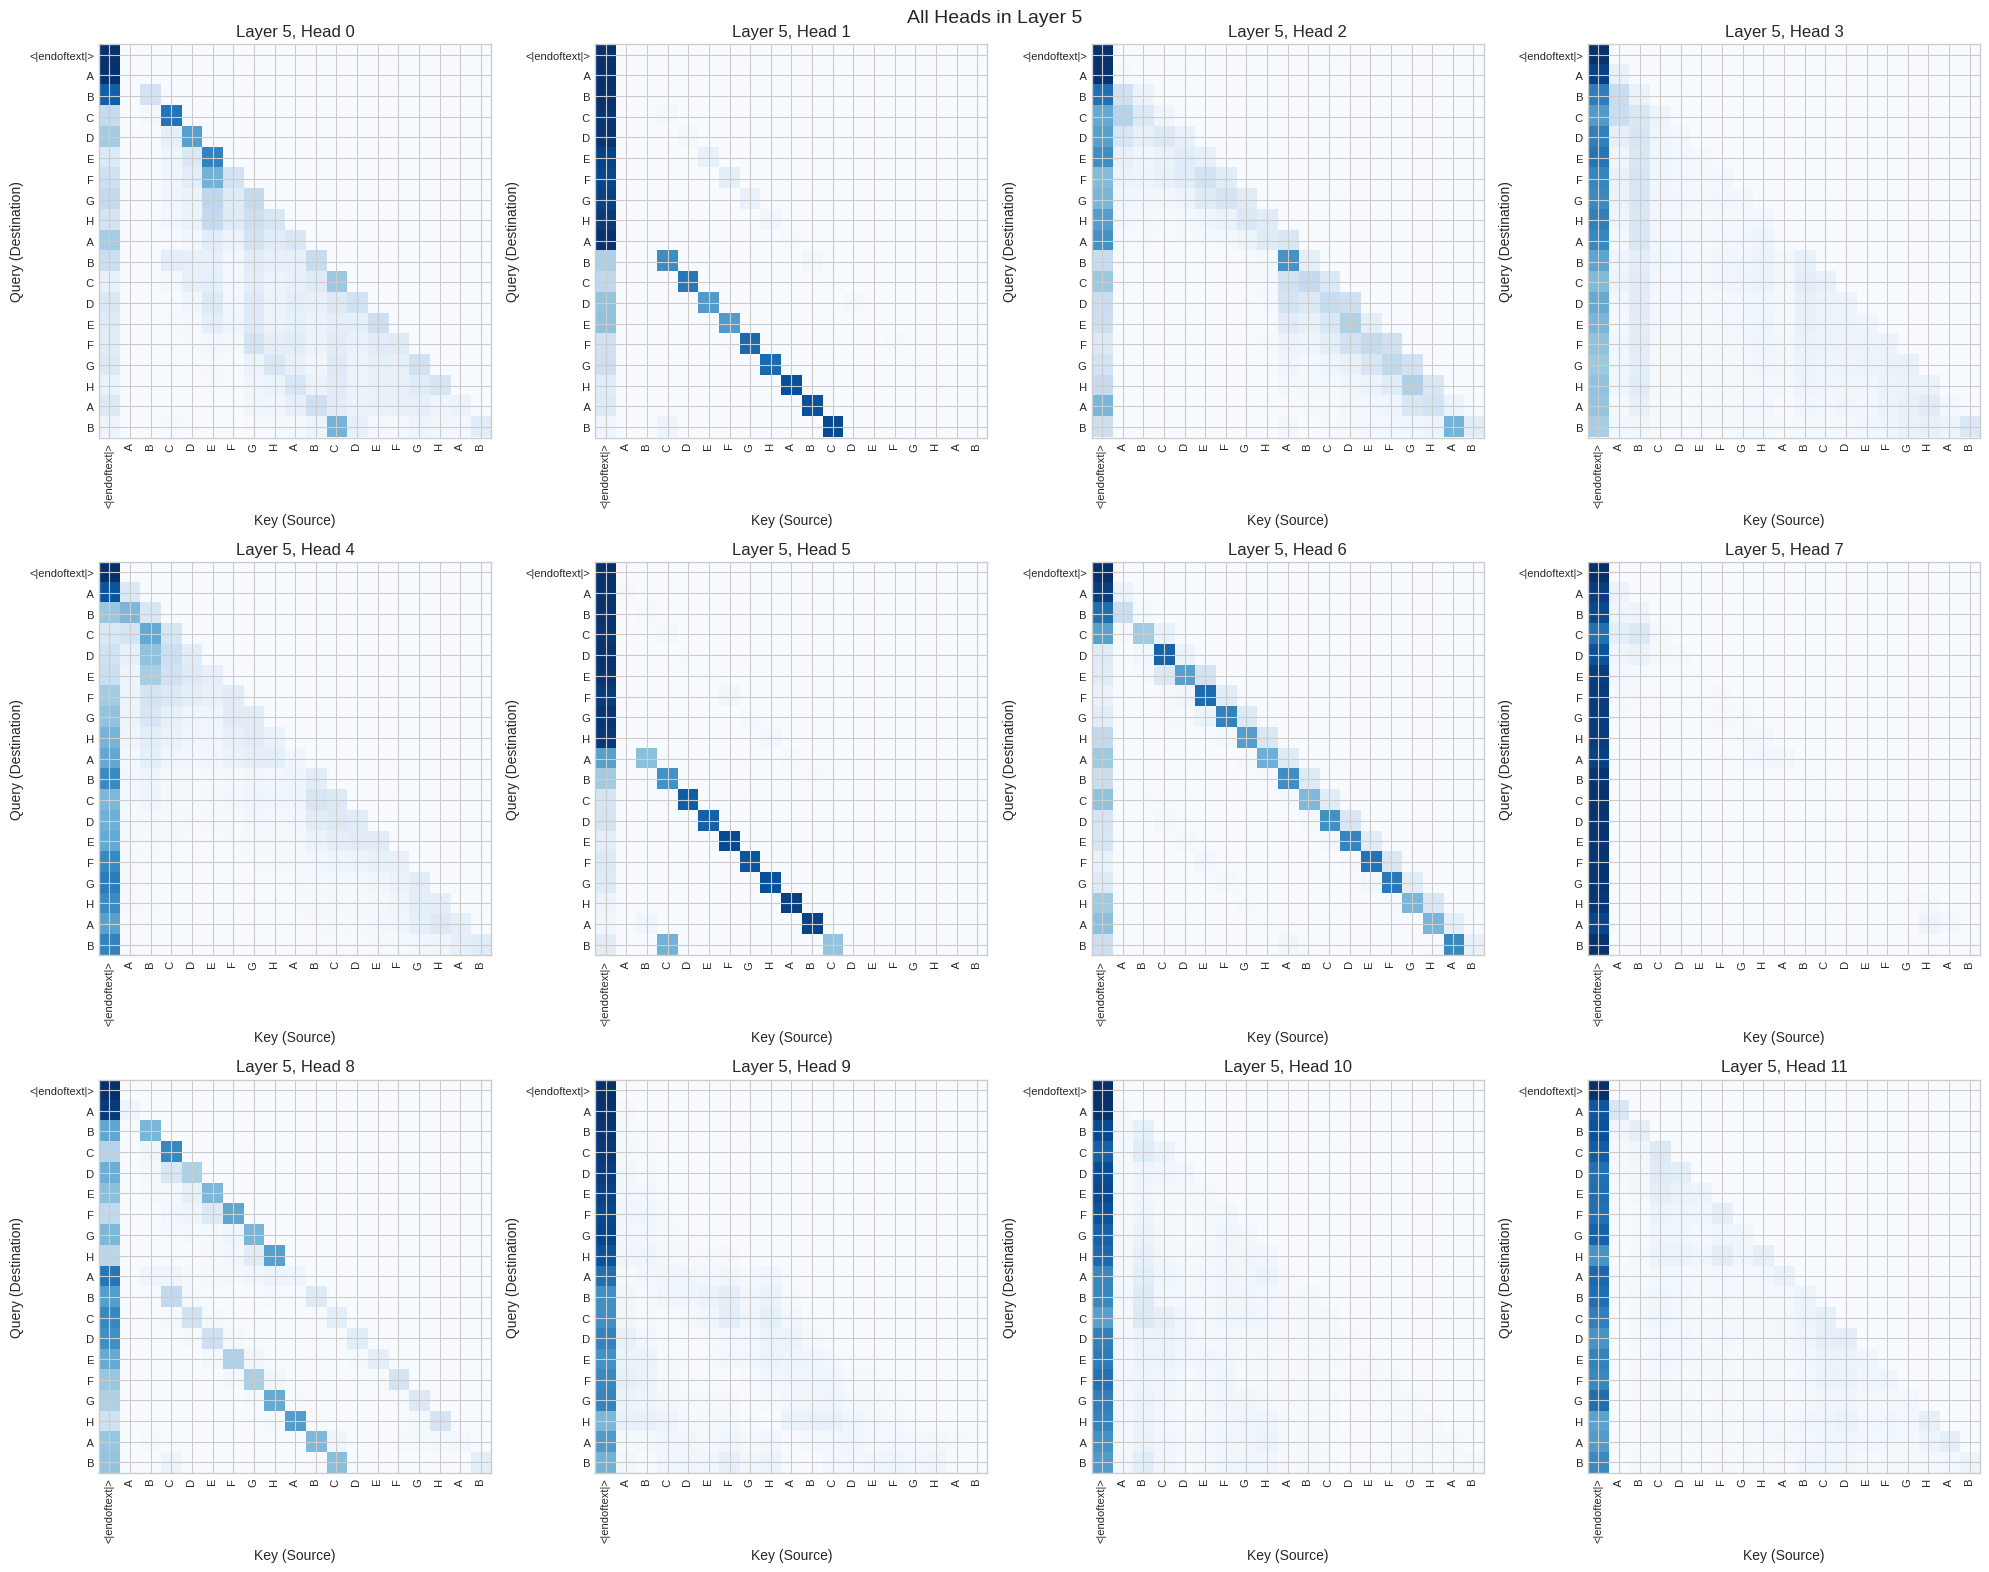

In [7]:
# Visualize all heads in a layer known to contain induction heads (layer 5 in GPT-2 small)
# Look for the characteristic diagonal stripe pattern
visualizer.plot_layer_heads(cache, tokens, layer=5, n_heads=model_info.n_heads)
plt.show()

In [35]:
# Interactive attention visualization (hover over cells to see values)
visualizer.interactive_attention(cache, tokens, layer=2)

## 4. Algorithmic Induction Head Detection

We use several metrics to algorithmically identify induction heads:

1. **Induction Score**: Measures attention on the "induction diagonal" - how much does the head attend to tokens that are `offset` positions back (where `offset` is the length of the repeated sequence)

2. **Prefix Matching Score**: How much does the head attend to positions where the previous token matches the previous token of the query

3. **Copying Score**: Correlation between attention patterns and token identity patterns

In [62]:
class InductionHeadDetector:
    """Algorithmic detection of induction heads."""
    
    @staticmethod
    def compute_induction_score(
        attention: torch.Tensor,
        offset: int
    ) -> float:
        """
        Compute induction score for a single head's attention pattern.
        
        The induction score measures how much the head attends to the position
        that is `offset` positions back - the characteristic diagonal stripe.
        
        Args:
            attention: Attention pattern [seq_len, seq_len]
            offset: The offset of the repeated sequence
            
        Returns:
            Mean attention on the induction diagonal
        """
        seq_len = attention.shape[0]
        
        if offset >= seq_len:
            return 0.0
        
        # Compute mean attention on the diagonal offset positions back
        diagonal_attn = []
        for i in range(offset, seq_len):
            diagonal_attn.append(attention[i, i - offset].item())
        
        return np.mean(diagonal_attn) if diagonal_attn else 0.0
    
    @staticmethod
    def compute_prefix_matching_score(
        attention: torch.Tensor,
        tokens: torch.Tensor
    ) -> float:
        """
        Compute prefix matching score.
        
        This measures how much the head attends to positions where the 
        PREVIOUS token matches the query's previous token. This is the
        core induction pattern: [A][B]...[A] -> predict [B].
        
        Args:
            attention: Attention pattern [seq_len, seq_len]
            tokens: Token IDs [seq_len]
            
        Returns:
            Prefix matching score
        """
        seq_len = attention.shape[0]
        tokens = tokens.squeeze()
        
        if seq_len < 3:
            return 0.0
        
        total_score = 0.0
        count = 0
        
        # For each query position (starting from position 2)
        for q in range(2, seq_len):
            prev_token = tokens[q - 1].item()
            
            # Find all key positions where the previous token matches
            matching_positions = []
            for k in range(1, q):  # Can only attend to earlier positions
                if tokens[k - 1].item() == prev_token:
                    matching_positions.append(k)
            
            if matching_positions:
                # Sum attention to matching positions
                attn_to_matches = sum(attention[q, k].item() for k in matching_positions)
                total_score += attn_to_matches
                count += 1
        
        return total_score / count if count > 0 else 0.0
    
    @staticmethod
    def detect_induction_heads(
        model: HookedTransformer,
        text: str,
        offset: Optional[int] = None,
        threshold: float = 0.1
    ) -> pd.DataFrame:
        """
        Detect induction heads in a model using multiple metrics.
        
        Args:
            model: The transformer model
            text: Input text with repeated patterns
            offset: Offset for induction score (auto-detected if None)
            threshold: Minimum score to be considered an induction head
            
        Returns:
            DataFrame with scores for each head
        """
        tokens = model.to_tokens(text)
        str_tokens = model.to_str_tokens(text)
        _, cache = model.run_with_cache(tokens)
        
        # Auto-detect offset by finding repeated subsequences
        if offset is None:
            offset = InductionHeadDetector._detect_repeat_offset(tokens[0])
        
        results = []
        
        for layer in range(model.cfg.n_layers):
            attention = cache["pattern", layer][0]  # [heads, seq, seq]
            
            for head in range(model.cfg.n_heads):
                attn_pattern = attention[head]
                
                # Compute scores
                induction_score = InductionHeadDetector.compute_induction_score(
                    attn_pattern, offset
                )
                prefix_score = InductionHeadDetector.compute_prefix_matching_score(
                    attn_pattern, tokens
                )
                
                # Combined score
                combined_score = (induction_score + prefix_score) / 2
                
                results.append({
                    'Layer': layer,
                    'Head': head,
                    'Induction Score': induction_score,
                    'Prefix Match Score': prefix_score,
                    'Combined Score': combined_score,
                    'Is Induction Head': combined_score > threshold
                })
        
        df = pd.DataFrame(results)
        return df.sort_values('Combined Score', ascending=False)
    
    @staticmethod
    def _detect_repeat_offset(tokens: torch.Tensor) -> int:
        """Auto-detect the offset of repeated patterns in tokens."""
        tokens = tokens.cpu().numpy()
        seq_len = len(tokens)
        
        # Try different offsets and find the one with best token matching
        best_offset = seq_len // 2
        best_match_rate = 0
        
        for offset in range(2, seq_len // 2 + 1):
            matches = 0
            total = 0
            for i in range(offset, seq_len):
                if tokens[i] == tokens[i - offset]:
                    matches += 1
                total += 1
            
            if total > 0:
                match_rate = matches / total
                if match_rate > best_match_rate:
                    best_match_rate = match_rate
                    best_offset = offset
        
        return best_offset
    
    @staticmethod
    def plot_induction_scores(
        df: pd.DataFrame,
        model_name: str,
        figsize: Tuple[int, int] = (6, 6)
    ) -> plt.Figure:
        """Visualize induction scores as a heatmap."""
        n_layers = df['Layer'].max() + 1
        n_heads = df['Head'].max() + 1
        
        # Create score matrices
        induction_matrix = np.zeros((n_layers, n_heads))
        prefix_matrix = np.zeros((n_layers, n_heads))
        
        for _, row in df.iterrows():
            induction_matrix[row['Layer'], row['Head']] = row['Induction Score']
            prefix_matrix[row['Layer'], row['Head']] = row['Prefix Match Score']
        
        fig, axes = plt.subplots(1, 1, figsize=figsize)
        
        # Induction scores
        im1 = axes.imshow(induction_matrix, cmap='Reds', aspect='auto')
        axes.set_xlabel('Head')
        axes.set_ylabel('Layer')
        axes.set_title(f'{model_name}: Induction Scores')
        plt.colorbar(im1, ax=axes)
        
        # Prefix matching scores  
        # im2 = axes[1].imshow(prefix_matrix, cmap='Reds', aspect='auto')
        # axes[1].set_xlabel('Head')
        # axes[1].set_ylabel('Layer')
        # axes[1].set_title(f'{model_name}: Prefix Matching Scores')
        # plt.colorbar(im2, ax=axes[1])
        
        plt.tight_layout()
        return fig
    
    @staticmethod
    def get_top_induction_heads(
        df: pd.DataFrame,
        n: int = 10
    ) -> pd.DataFrame:
        """Get the top N induction heads by combined score."""
        return df.nlargest(n, 'Combined Score')[
            ['Layer', 'Head', 'Induction Score', 'Prefix Match Score', 'Combined Score']
        ]

In [ ]:
# Initialize detector
detector = InductionHeadDetector()

# Detect induction heads in GPT-2 Small
example = example_manager.get_example("abab_pattern")
model = model_manager.get_model("GPT-2 Small").model

scores_df = detector.detect_induction_heads(model, example.text)
print("Top 10 Induction Head Candidates:")
detector.get_top_induction_heads(scores_df, n=10)

Top 10 Induction Head Candidates:


,Layer,Head,Induction Score,Prefix Match Score,Combined Score
5,0,5,0.475966,0.557917,0.516942
36,3,0,0.474260,0.504575,0.489417
1,0,1,0.399173,0.466284,0.432729
23,1,11,0.354886,0.393367,0.374126
10,0,10,0.158160,0.159269,0.158714
117,9,9,0.156619,0.080852,0.118736
78,6,6,0.118320,0.055587,0.086954
132,11,0,0.081266,0.089574,0.085420
70,5,10,0.109883,0.058103,0.083993
130,10,10,0.117994,0.039133,0.078564


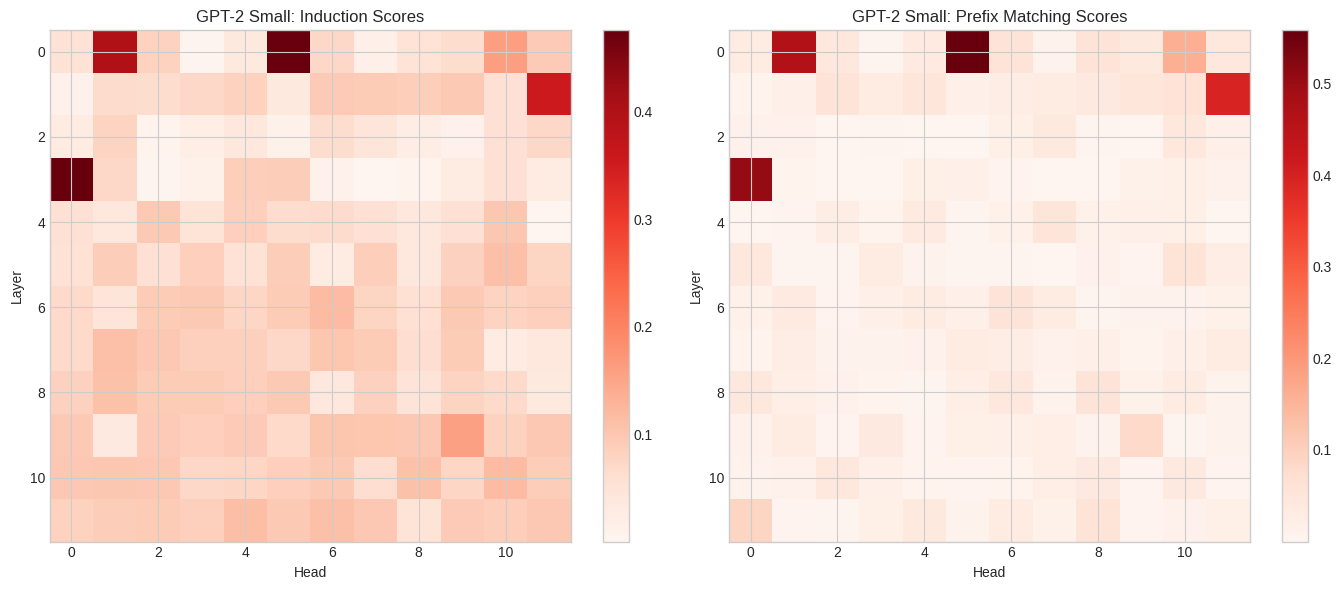

In [11]:
# Visualize induction scores across all heads
detector.plot_induction_scores(scores_df, "GPT-2 Small")
plt.show()

## 5. Ablation Studies

Ablation allows us to "knock out" specific heads by zeroing their outputs and observe how this affects model behavior and other heads. This is useful for:
- Verifying that identified induction heads are actually responsible for the behavior
- Understanding the causal relationships between heads
- Testing if multiple heads provide redundant functionality

In [117]:
class AblationFramework:
    """Framework for ablating attention heads and analyzing effects."""
    
    @staticmethod
    def create_head_ablation_hook(
        heads_to_ablate: List[Tuple[int, int]]
    ):
        """
        Create a hook function that zeros out specified heads.
        
        Args:
            heads_to_ablate: List of (layer, head) tuples to zero out
            
        Returns:
            Hook function for use with TransformerLens
        """
        ablate_layers = {layer for layer, _ in heads_to_ablate}
        heads_by_layer = {}
        for layer, head in heads_to_ablate:
            if layer not in heads_by_layer:
                heads_by_layer[layer] = []
            heads_by_layer[layer].append(head)
        
        def hook_fn(z: torch.Tensor, hook: HookPoint):
            # Extract layer number from hook name (e.g., "blocks.5.attn.hook_z")
            layer = int(hook.name.split('.')[1])
            
            if layer in heads_by_layer:
                # z shape: [batch, seq, n_heads, d_head]
                for head in heads_by_layer[layer]:
                    z[:, :, head, :] = 0
            
            return z
        
        return hook_fn, ablate_layers
    
    @staticmethod
    def run_with_ablation(
        model: HookedTransformer,
        text: str,
        heads_to_ablate: List[Tuple[int, int]]
    ) -> Tuple[torch.Tensor, ActivationCache]:
        """
        Run model with specified heads ablated (zeroed out).
        
        Args:
            model: The transformer model
            text: Input text
            heads_to_ablate: List of (layer, head) tuples to zero out
            
        Returns:
            Tuple of (logits, cache) with ablation applied
        """
        tokens = model.to_tokens(text)
        
        hook_fn, ablate_layers = AblationFramework.create_head_ablation_hook(heads_to_ablate)
        
        # Hook at hook_z (per-head output BEFORE W_O projection)
        # hook_z has shape [batch, seq, n_heads, d_head] - can zero individual heads
        # hook_result has shape [batch, seq, d_model] AFTER heads combined - can't isolate heads
        hook_points = [(f"blocks.{layer}.attn.hook_z", hook_fn) 
                       for layer in ablate_layers]
        
        with model.hooks(fwd_hooks=hook_points):
            logits, cache = model.run_with_cache(tokens)
        
        return logits, cache
    
    @staticmethod
    def compare_activations(
        cache_original: ActivationCache,
        cache_ablated: ActivationCache,
        model: HookedTransformer,
        start_layer: int = 0
    ) -> Tuple[pd.DataFrame, np.ndarray]:
        """
        Compare attention patterns between original and ablated runs.
        
        Args:
            start_layer: Only compare layers >= this (to see downstream effects)
        
        Returns:
            Tuple of (DataFrame with metrics, matrix of mean diffs [n_layers, n_heads])
        """
        n_layers = model.cfg.n_layers
        n_heads = model.cfg.n_heads
        diff_matrix = np.zeros((n_layers, n_heads))
        results = []
        
        for layer in range(n_layers):
            orig_attn = cache_original["pattern", layer][0]  # [heads, seq, seq]
            ablated_attn = cache_ablated["pattern", layer][0]
            
            for head in range(n_heads):
                orig_pattern = orig_attn[head]
                ablated_pattern = ablated_attn[head]
                
                # Compute difference metrics
                diff = (orig_pattern - ablated_pattern).abs()
                mean_diff = diff.mean().item()
                diff_matrix[layer, head] = mean_diff
                
                if layer >= start_layer:
                    results.append({
                        'Layer': layer,
                        'Head': head,
                        'Mean Abs Diff': mean_diff,
                        'Max Abs Diff': diff.max().item(),
                        'Frobenius Norm': torch.norm(diff).item()
                    })
        
        df = pd.DataFrame(results).sort_values('Mean Abs Diff', ascending=False)
        return df, diff_matrix
    
    @staticmethod
    def plot_ablation_heatmap(
        diff_matrix: np.ndarray,
        ablated_heads: List[Tuple[int, int]],
        title: Optional[str] = None,
        figsize: Tuple[int, int] = (10, 8)
    ) -> plt.Figure:
        """
        Plot heatmap showing how much each head's attention pattern changed.
        
        Args:
            diff_matrix: Matrix of mean abs differences [n_layers, n_heads]
            ablated_heads: List of (layer, head) tuples that were ablated
            title: Optional title
        """
        fig, ax = plt.subplots(figsize=figsize)
        
        im = ax.imshow(diff_matrix, cmap='Reds', aspect='auto')
        ax.set_xlabel('Head')
        ax.set_ylabel('Layer')
        
        # Mark ablated heads with X
        for layer, head in ablated_heads:
            ax.plot(head, layer, 'bx', markersize=12, markeredgewidth=3)
        
        ablated_str = ', '.join([f'L{l}H{h}' for l, h in ablated_heads])
        if title:
            ax.set_title(title)
        else:
            ax.set_title(f'Attention Pattern Changes After Ablating {ablated_str}\n(blue X = ablated heads)')
        
        plt.colorbar(im, ax=ax, label='Mean Abs Difference')
        plt.tight_layout()
        return fig
    
    @staticmethod
    def plot_ablation_comparison(
        cache_original: ActivationCache,
        cache_ablated: ActivationCache,
        model: HookedTransformer,
        ablated_heads: List[Tuple[int, int]],
        figsize: Tuple[int, int] = (14, 10)
    ) -> plt.Figure:
        """
        Comprehensive visualization of ablation effects across all heads.
        Shows heatmap of pattern changes + induction score changes.
        """
        n_layers = model.cfg.n_layers
        n_heads = model.cfg.n_heads
        
        # Compute diff matrix and induction score changes
        diff_matrix = np.zeros((n_layers, n_heads))
        orig_induction = np.zeros((n_layers, n_heads))
        ablated_induction = np.zeros((n_layers, n_heads))
        
        # Get tokens for induction score (need to detect offset)
        # We'll use a simple diagonal check (offset=1 as proxy)
        
        for layer in range(n_layers):
            orig_attn = cache_original["pattern", layer][0]
            ablated_attn = cache_ablated["pattern", layer][0]
            
            for head in range(n_heads):
                # Pattern difference
                diff = (orig_attn[head] - ablated_attn[head]).abs()
                diff_matrix[layer, head] = diff.mean().item()
                
                # Induction-like score (mean of off-diagonal attention)
                seq_len = orig_attn.shape[-1]
                if seq_len > 2:
                    # Check attention to positions 1 step back (simple proxy)
                    orig_diag = torch.diagonal(orig_attn[head], offset=-1).mean().item()
                    ablated_diag = torch.diagonal(ablated_attn[head], offset=-1).mean().item()
                    orig_induction[layer, head] = orig_diag
                    ablated_induction[layer, head] = ablated_diag
        
        induction_change = ablated_induction - orig_induction
        
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        
        # 1. Pattern changes heatmap
        im1 = axes[0].imshow(diff_matrix, cmap='Reds', aspect='auto')
        for layer, head in ablated_heads:
            axes[0].plot(head, layer, 'bx', markersize=10, markeredgewidth=2)
        axes[0].set_xlabel('Head')
        axes[0].set_ylabel('Layer')
        axes[0].set_title('Attention Pattern Changes\n(blue X = ablated)')
        plt.colorbar(im1, ax=axes[0], label='Mean Abs Diff')
        
        # 2. Original induction scores
        im2 = axes[1].imshow(orig_induction, cmap='Blues', aspect='auto')
        for layer, head in ablated_heads:
            axes[1].plot(head, layer, 'rx', markersize=10, markeredgewidth=2)
        axes[1].set_xlabel('Head')
        axes[1].set_ylabel('Layer')
        axes[1].set_title('Original Prev-Token Attention\n(proxy for induction)')
        plt.colorbar(im2, ax=axes[1])
        
        # 3. Change in induction scores
        max_change = max(abs(induction_change.min()), abs(induction_change.max()), 1e-8)
        im3 = axes[2].imshow(induction_change, cmap='RdBu_r', aspect='auto',
                            vmin=-max_change, vmax=max_change)
        for layer, head in ablated_heads:
            axes[2].plot(head, layer, 'kx', markersize=10, markeredgewidth=2)
        axes[2].set_xlabel('Head')
        axes[2].set_ylabel('Layer')
        axes[2].set_title('Change in Prev-Token Attention\n(red=increased, blue=decreased)')
        plt.colorbar(im3, ax=axes[2])
        
        ablated_str = ', '.join([f'L{l}H{h}' for l, h in ablated_heads])
        fig.suptitle(f'Effects of Ablating: {ablated_str}', fontsize=12, y=1.02)
        plt.tight_layout()
        return fig
    
    @staticmethod
    def plot_single_head_comparison(
        cache_original: ActivationCache,
        cache_ablated: ActivationCache,
        tokens: List[str],
        layer: int,
        head: int,
        ablated_heads: List[Tuple[int, int]],
        figsize: Tuple[int, int] = (16, 5)
    ) -> plt.Figure:
        """
        Visualize a single head's attention pattern before/after ablation.
        """
        orig_attn = cache_original["pattern", layer][0, head].detach().cpu().numpy()
        ablated_attn = cache_ablated["pattern", layer][0, head].detach().cpu().numpy()
        diff = orig_attn - ablated_attn
        
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        
        # Original
        im1 = axes[0].imshow(orig_attn, cmap='Blues', aspect='auto', vmin=0, vmax=1)
        axes[0].set_title(f'Original L{layer}H{head}')
        axes[0].set_xlabel('Key')
        axes[0].set_ylabel('Query')
        plt.colorbar(im1, ax=axes[0])
        
        # After ablation
        im2 = axes[1].imshow(ablated_attn, cmap='Blues', aspect='auto', vmin=0, vmax=1)
        ablated_str = ', '.join([f'L{l}H{h}' for l, h in ablated_heads])
        axes[1].set_title(f'After Ablating {ablated_str}')
        axes[1].set_xlabel('Key')
        axes[1].set_ylabel('Query')
        plt.colorbar(im2, ax=axes[1])
        
        # Difference
        max_diff = max(abs(diff.min()), abs(diff.max()), 1e-8)
        im3 = axes[2].imshow(diff, cmap='RdBu', aspect='auto', 
                            vmin=-max_diff, vmax=max_diff)
        axes[2].set_title('Difference (Original - Ablated)')
        axes[2].set_xlabel('Key')
        axes[2].set_ylabel('Query')
        plt.colorbar(im3, ax=axes[2])
        
        plt.tight_layout()
        return fig
    
    @staticmethod
    def measure_induction_change(
        model: HookedTransformer,
        text: str,
        heads_to_ablate: List[Tuple[int, int]],
        target_head: Tuple[int, int],
        offset: Optional[int] = None
    ) -> Dict:
        """
        Measure how ablating certain heads affects a target head's induction behavior.
        """
        tokens = model.to_tokens(text)
        
        if offset is None:
            offset = InductionHeadDetector._detect_repeat_offset(tokens[0])
        
        _, cache_orig = model.run_with_cache(tokens)
        orig_attn = cache_orig["pattern", target_head[0]][0, target_head[1]]
        orig_score = InductionHeadDetector.compute_induction_score(orig_attn, offset)
        
        _, cache_ablated = AblationFramework.run_with_ablation(model, text, heads_to_ablate)
        ablated_attn = cache_ablated["pattern", target_head[0]][0, target_head[1]]
        ablated_score = InductionHeadDetector.compute_induction_score(ablated_attn, offset)
        
        return {
            'target_head': target_head,
            'ablated_heads': heads_to_ablate,
            'original_induction_score': orig_score,
            'ablated_induction_score': ablated_score,
            'score_change': ablated_score - orig_score,
            'percent_change': ((ablated_score - orig_score) / orig_score * 100) if orig_score > 0 else 0
        }
    
    @staticmethod
    def ablation_sweep(
        model: HookedTransformer,
        text: str,
        candidate_heads: List[Tuple[int, int]],
        threshold: float = 0.1
    ) -> pd.DataFrame:
        """
        Ablate each candidate head individually and measure effect on model loss.
        """
        tokens = model.to_tokens(text)

        with torch.no_grad():
            orig_logits = model(tokens)
            orig_loss = torch.nn.functional.cross_entropy(
                orig_logits[0, :-1].flatten(0, -2),
                tokens[0, 1:].flatten(),
                reduction='mean'
            ).item()

        results = []

        for layer, head in candidate_heads:
            ablated_logits, _ = AblationFramework.run_with_ablation(
                model, text, [(layer, head)]
            )

            with torch.no_grad():
                ablated_loss = torch.nn.functional.cross_entropy(
                    ablated_logits[0, :-1].flatten(0, -2),
                    tokens[0, 1:].flatten(),
                    reduction='mean'
                ).item()

            loss_increase = ablated_loss - orig_loss

            results.append({
                'Layer': layer,
                'Head': head,
                'Original Loss': orig_loss,
                'Ablated Loss': ablated_loss,
                'Loss Increase': loss_increase,
                'Percent Increase': (loss_increase / orig_loss * 100) if orig_loss > 0 else 0
            })

        return pd.DataFrame(results).sort_values('Loss Increase', ascending=False)

    @staticmethod
    def compare_generation(
        model: HookedTransformer,
        prompt: str,
        heads_to_ablate: List[Tuple[int, int]],
        max_new_tokens: int = 20,
        temperature: float = 0.0,
        top_k: Optional[int] = None,
        verbose: bool = True
    ) -> Dict:
        """
        Compare text generation with and without induction heads ablated.

        This lets you see directly how knocking out induction heads affects
        the model's ability to continue patterns like "A B C D E F G H A B C D E F G H A B"

        Args:
            model: The transformer model
            prompt: Input text (ideally with repeated patterns)
            heads_to_ablate: List of (layer, head) tuples to zero out
            max_new_tokens: Number of tokens to generate
            temperature: Sampling temperature (0 = greedy)
            top_k: Top-k sampling (None = no top-k)
            verbose: Whether to print results

        Returns:
            Dict with original/ablated generations and token-by-token comparison
        """
        tokens = model.to_tokens(prompt)
        prompt_len = tokens.shape[1]

        # Setup hook for ablation
        hook_fn, ablate_layers = AblationFramework.create_head_ablation_hook(heads_to_ablate)
        hook_points = [(f"blocks.{layer}.attn.hook_z", hook_fn)
                       for layer in ablate_layers]

        # Generate without ablation
        generated_normal = tokens.clone()
        with torch.no_grad():
            for _ in range(max_new_tokens):
                logits = model(generated_normal)
                next_token_logits = logits[0, -1, :]

                if temperature == 0:
                    next_token = next_token_logits.argmax().unsqueeze(0).unsqueeze(0)
                else:
                    probs = torch.softmax(next_token_logits / temperature, dim=-1)
                    if top_k is not None:
                        top_probs, top_indices = probs.topk(top_k)
                        probs = torch.zeros_like(probs).scatter_(-1, top_indices, top_probs)
                        probs = probs / probs.sum()
                    next_token = torch.multinomial(probs, 1).unsqueeze(0)

                generated_normal = torch.cat([generated_normal, next_token], dim=1)

        # Generate with ablation
        generated_ablated = tokens.clone()
        with torch.no_grad():
            for _ in range(max_new_tokens):
                with model.hooks(fwd_hooks=hook_points):
                    logits = model(generated_ablated)
                next_token_logits = logits[0, -1, :]

                if temperature == 0:
                    next_token = next_token_logits.argmax().unsqueeze(0).unsqueeze(0)
                else:
                    probs = torch.softmax(next_token_logits / temperature, dim=-1)
                    if top_k is not None:
                        top_probs, top_indices = probs.topk(top_k)
                        probs = torch.zeros_like(probs).scatter_(-1, top_indices, top_probs)
                        probs = probs / probs.sum()
                    next_token = torch.multinomial(probs, 1).unsqueeze(0)

                generated_ablated = torch.cat([generated_ablated, next_token], dim=1)

        # Convert to strings
        normal_tokens = model.to_str_tokens(generated_normal[0])
        ablated_tokens = model.to_str_tokens(generated_ablated[0])

        normal_text = model.to_string(generated_normal[0])
        ablated_text = model.to_string(generated_ablated[0])

        # Token-by-token comparison for generated portion
        comparison = []
        for i in range(prompt_len, min(len(normal_tokens), len(ablated_tokens))):
            comparison.append({
                'Position': i,
                'Normal': normal_tokens[i],
                'Ablated': ablated_tokens[i],
                'Match': normal_tokens[i] == ablated_tokens[i]
            })

        comparison_df = pd.DataFrame(comparison)
        match_rate = comparison_df['Match'].mean() if len(comparison_df) > 0 else 0.0

        result = {
            'prompt': prompt,
            'ablated_heads': heads_to_ablate,
            'normal_generation': normal_text,
            'ablated_generation': ablated_text,
            'normal_new_tokens': normal_tokens[prompt_len:],
            'ablated_new_tokens': ablated_tokens[prompt_len:],
            'comparison': comparison_df,
            'match_rate': match_rate
        }

        if verbose:
            ablated_str = ', '.join([f'L{l}H{h}' for l, h in heads_to_ablate])
            print("=" * 70)
            print(f"GENERATION COMPARISON (Ablating: {ablated_str})")
            print("=" * 70)
            print(f"\nPrompt: {prompt}")
            print(f"\n{'─' * 70}")
            print("NORMAL GENERATION:")
            print(f"  {normal_text}")
            print(f"\n{'─' * 70}")
            print("ABLATED GENERATION:")
            print(f"  {ablated_text}")
            print(f"\n{'─' * 70}")
            print("TOKEN-BY-TOKEN COMPARISON (generated tokens only):")
            print(comparison_df.to_string(index=False))
            print(f"\nMatch rate: {match_rate:.1%}")
            print("=" * 70)

        return result

    @staticmethod
    def compare_generation_attention(
        model: HookedTransformer,
        prompt: str,
        heads_to_ablate: List[Tuple[int, int]],
        heads_to_visualize: Optional[List[Tuple[int, int]]] = None,
        max_new_tokens: int = 10,
        temperature: float = 0.0,
        figsize: Tuple[int, int] = (16, 6)
    ) -> Dict:
        """
        Compare attention patterns during generation with and without ablation.

        Generates text normally and with ablation, then visualizes attention 
        patterns for specified heads side-by-side.

        Args:
            model: The transformer model
            prompt: Input text (ideally with repeated patterns)
            heads_to_ablate: List of (layer, head) tuples to zero out
            heads_to_visualize: Heads to show attention for (defaults to ablated heads)
            max_new_tokens: Number of tokens to generate
            temperature: Sampling temperature (0 = greedy)
            figsize: Figure size for each head's comparison plot

        Returns:
            Dict with caches, generated sequences, and figures
        """
        if heads_to_visualize is None:
            heads_to_visualize = heads_to_ablate

        tokens = model.to_tokens(prompt)
        prompt_len = tokens.shape[1]

        # Setup hook for ablation
        hook_fn, ablate_layers = AblationFramework.create_head_ablation_hook(heads_to_ablate)
        hook_points = [(f"blocks.{layer}.attn.hook_z", hook_fn)
                       for layer in ablate_layers]

        # Generate without ablation (with cache on final sequence)
        generated_normal = tokens.clone()
        with torch.no_grad():
            for _ in range(max_new_tokens):
                logits = model(generated_normal)
                next_token_logits = logits[0, -1, :]
                if temperature == 0:
                    next_token = next_token_logits.argmax().unsqueeze(0).unsqueeze(0)
                else:
                    probs = torch.softmax(next_token_logits / temperature, dim=-1)
                    next_token = torch.multinomial(probs, 1).unsqueeze(0)
                generated_normal = torch.cat([generated_normal, next_token], dim=1)
        
        # Run final sequence through to get cache
        _, cache_normal = model.run_with_cache(generated_normal)
        normal_str_tokens = model.to_str_tokens(generated_normal[0])

        # Generate with ablation (with cache on final sequence)
        generated_ablated = tokens.clone()
        with torch.no_grad():
            for _ in range(max_new_tokens):
                with model.hooks(fwd_hooks=hook_points):
                    logits = model(generated_ablated)
                next_token_logits = logits[0, -1, :]
                if temperature == 0:
                    next_token = next_token_logits.argmax().unsqueeze(0).unsqueeze(0)
                else:
                    probs = torch.softmax(next_token_logits / temperature, dim=-1)
                    next_token = torch.multinomial(probs, 1).unsqueeze(0)
                generated_ablated = torch.cat([generated_ablated, next_token], dim=1)
        
        # Run final ablated sequence through to get cache (with ablation still active)
        with model.hooks(fwd_hooks=hook_points):
            _, cache_ablated = model.run_with_cache(generated_ablated)
        ablated_str_tokens = model.to_str_tokens(generated_ablated[0])

        normal_text = model.to_string(generated_normal[0])
        ablated_text = model.to_string(generated_ablated[0])

        ablated_str = ', '.join([f'L{l}H{h}' for l, h in heads_to_ablate])
        print("=" * 70)
        print(f"GENERATION ATTENTION COMPARISON (Ablating: {ablated_str})")
        print("=" * 70)
        print(f"\nNormal:  {normal_text}")
        print(f"Ablated: {ablated_text}")
        print("=" * 70)

        # Create attention comparison plots for each head
        figures = []
        for layer, head in heads_to_visualize:
            fig, axes = plt.subplots(1, 3, figsize=figsize)
            
            # Normal attention
            normal_attn = cache_normal["pattern", layer][0, head].detach().cpu().numpy()
            seq_len_normal = len(normal_str_tokens)
            im1 = axes[0].imshow(normal_attn, cmap='Blues', aspect='auto', vmin=0, vmax=1)
            axes[0].set_title(f'Normal Generation\nL{layer}H{head}')
            axes[0].set_xlabel('Key')
            axes[0].set_ylabel('Query')
            # Mark prompt boundary
            axes[0].axvline(x=prompt_len-0.5, color='red', linestyle='--', alpha=0.7, label='Prompt end')
            axes[0].axhline(y=prompt_len-0.5, color='red', linestyle='--', alpha=0.7)
            plt.colorbar(im1, ax=axes[0])
            
            # Ablated attention
            ablated_attn = cache_ablated["pattern", layer][0, head].detach().cpu().numpy()
            seq_len_ablated = len(ablated_str_tokens)
            im2 = axes[1].imshow(ablated_attn, cmap='Blues', aspect='auto', vmin=0, vmax=1)
            axes[1].set_title(f'Ablated Generation\nL{layer}H{head}')
            axes[1].set_xlabel('Key')
            axes[1].set_ylabel('Query')
            axes[1].axvline(x=prompt_len-0.5, color='red', linestyle='--', alpha=0.7)
            axes[1].axhline(y=prompt_len-0.5, color='red', linestyle='--', alpha=0.7)
            plt.colorbar(im2, ax=axes[1])
            
            # Difference (need to handle potentially different sizes)
            min_len = min(seq_len_normal, seq_len_ablated)
            diff = normal_attn[:min_len, :min_len] - ablated_attn[:min_len, :min_len]
            max_diff = max(abs(diff.min()), abs(diff.max()), 1e-8)
            im3 = axes[2].imshow(diff, cmap='RdBu', aspect='auto', vmin=-max_diff, vmax=max_diff)
            axes[2].set_title(f'Difference (Normal - Ablated)\nL{layer}H{head}')
            axes[2].set_xlabel('Key')
            axes[2].set_ylabel('Query')
            axes[2].axvline(x=prompt_len-0.5, color='green', linestyle='--', alpha=0.7)
            axes[2].axhline(y=prompt_len-0.5, color='green', linestyle='--', alpha=0.7)
            plt.colorbar(im3, ax=axes[2])
            
            is_ablated = (layer, head) in heads_to_ablate
            status = " (ABLATED)" if is_ablated else ""
            fig.suptitle(f'Attention Pattern: Layer {layer}, Head {head}{status}', fontsize=12)
            plt.tight_layout()
            figures.append(fig)
            plt.show()

        return {
            'normal_text': normal_text,
            'ablated_text': ablated_text,
            'normal_tokens': normal_str_tokens,
            'ablated_tokens': ablated_str_tokens,
            'cache_normal': cache_normal,
            'cache_ablated': cache_ablated,
            'figures': figures
        }

In [ ]:
# Example: Ablate identified induction heads and see the effect
# Initialize ablation framework
ablation = AblationFramework()

model = model_manager.get_model("GPT-2 Small").model
example = example_manager.get_example("abab_pattern")

# Get the top induction head candidates
top_heads = detector.get_top_induction_heads(scores_df, n=5)
print("Top induction head candidates:")
print(top_heads)

# Select heads to ablate (top 2)
heads_to_ablate = [(int(row['Layer']), int(row['Head'])) for _, row in top_heads.head(2).iterrows()]
print(f"\nAblating heads: {heads_to_ablate}")

Top induction head candidates:
    Layer  Head  Induction Score  Prefix Match Score  Combined Score
5       0     5         0.475966            0.557917        0.516942
36      3     0         0.474260            0.504575        0.489417
1       0     1         0.399173            0.466284        0.432729
23      1    11         0.354886            0.393367        0.374126
10      0    10         0.158160            0.159269        0.158714

Ablating heads: [(0, 5), (3, 0)]


In [26]:
# Run model with and without ablation
tokens = model.to_tokens(example.text)
str_tokens = model.to_str_tokens(example.text)

# Original run
_, cache_original = model.run_with_cache(tokens)

# Ablated run
_, cache_ablated = ablation.run_with_ablation(model, example.text, heads_to_ablate)

# Compare activations - which heads changed the most?
diff_df = ablation.compare_activations(cache_original, cache_ablated, model)
print("Heads most affected by ablation:")
diff_df.head(10)

Heads most affected by ablation:


,Layer,Head,Mean Abs Diff,Max Abs Diff,Frobenius Norm
0,0,0,0.0,0.0,0.0
1,0,1,0.0,0.0,0.0
92,7,8,0.0,0.0,0.0
93,7,9,0.0,0.0,0.0
94,7,10,0.0,0.0,0.0
95,7,11,0.0,0.0,0.0
96,8,0,0.0,0.0,0.0
97,8,1,0.0,0.0,0.0
98,8,2,0.0,0.0,0.0
99,8,3,0.0,0.0,0.0


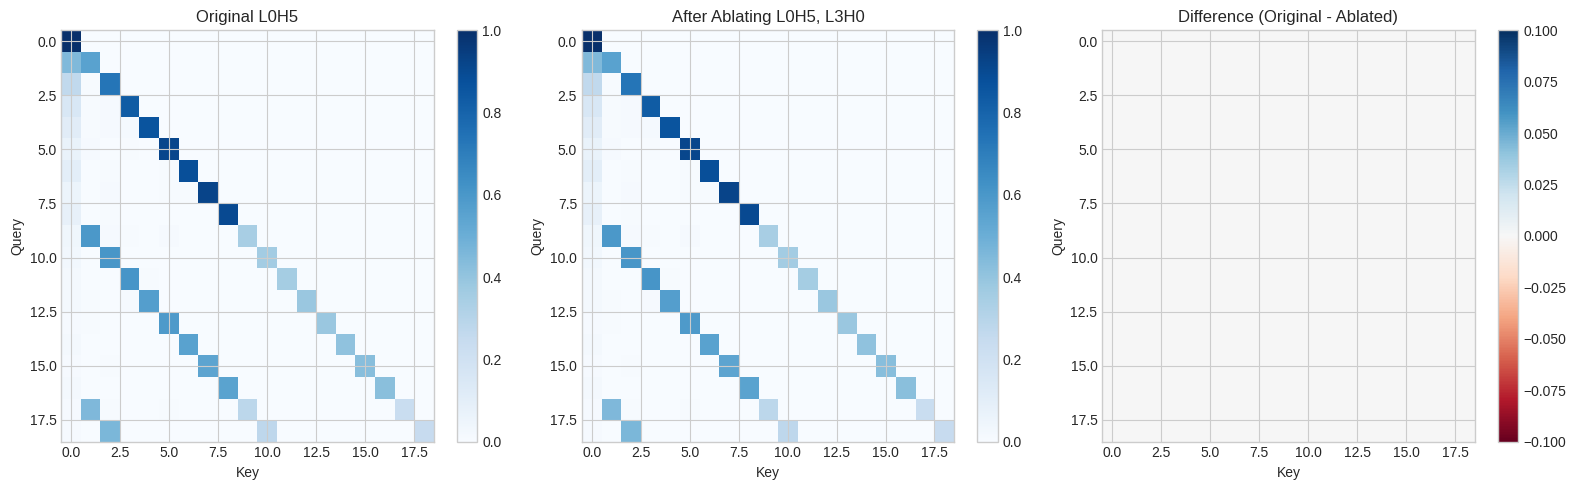

In [27]:
# Visualize how a specific head's attention pattern changed after ablation
# Pick one of the ablated heads to inspect
target_layer, target_head = heads_to_ablate[0]
ablation.plot_ablation_comparison(
    cache_original, cache_ablated, str_tokens,
    target_layer, target_head, heads_to_ablate
)
plt.show()

In [28]:
# Ablation sweep: measure which heads matter most for loss on repeated sequences
# Test the top candidate induction heads
candidate_heads = [(int(row['Layer']), int(row['Head'])) for _, row in top_heads.iterrows()]
sweep_results = ablation.ablation_sweep(model, example.text, candidate_heads)
print("Effect of ablating each head on model loss:")
sweep_results

Effect of ablating each head on model loss:


,Layer,Head,Original Loss,Ablated Loss,Loss Increase,Percent Increase
0,0,5,1.889584,1.889584,0.0,0.0
1,3,0,1.889584,1.889584,0.0,0.0
2,0,1,1.889584,1.889584,0.0,0.0
3,1,11,1.889584,1.889584,0.0,0.0
4,0,10,1.889584,1.889584,0.0,0.0


## 6. Cross-Model Comparison

Compare induction heads across different models to identify similar patterns and universal behaviors.

In [7]:
class ModelComparator:
    """Tools for comparing induction heads across models."""
    
    @staticmethod
    def compare_induction_heads(
        model_manager: ModelManager,
        example: Example,
        threshold: float = 0.1
    ) -> Dict[str, pd.DataFrame]:
        """
        Detect induction heads in all loaded models and return comparison.
        
        Returns dict mapping model name to its induction scores DataFrame.
        """
        results = {}
        
        for model_name in model_manager.list_models():
            model_info = model_manager.get_model(model_name)
            scores = detector.detect_induction_heads(
                model_info.model, example.text, threshold=threshold
            )
            results[model_name] = scores
        
        return results
    
    @staticmethod
    def plot_comparison_heatmaps(
        comparison_results: Dict[str, pd.DataFrame],
        metric: str = 'Combined Score',
        figsize: Tuple[int, int] = (16, 6)
    ) -> plt.Figure:
        """Plot induction score heatmaps side by side for comparison."""
        n_models = len(comparison_results)
        fig, axes = plt.subplots(1, n_models, figsize=figsize)
        
        if n_models == 1:
            axes = [axes]
        
        for ax, (model_name, df) in zip(axes, comparison_results.items()):
            n_layers = df['Layer'].max() + 1
            n_heads = df['Head'].max() + 1
            
            matrix = np.zeros((n_layers, n_heads))
            for _, row in df.iterrows():
                matrix[row['Layer'], row['Head']] = row[metric]
            
            im = ax.imshow(matrix, cmap='Reds', aspect='auto')
            ax.set_xlabel('Head')
            ax.set_ylabel('Layer')
            ax.set_title(f'{model_name}\n{metric}')
            plt.colorbar(im, ax=ax)
        
        plt.tight_layout()
        return fig
    
    @staticmethod
    def find_similar_heads(
        comparison_results: Dict[str, pd.DataFrame],
        top_n: int = 5,
        metric: str = 'Combined Score'
    ) -> pd.DataFrame:
        """
        Find heads with similar relative positions across models.
        
        This normalizes positions by total layers/heads to compare 
        architecturally similar heads.
        """
        all_top_heads = []
        
        for model_name, df in comparison_results.items():
            n_layers = df['Layer'].max() + 1
            n_heads = df['Head'].max() + 1
            
            top = df.nlargest(top_n, metric).copy()
            top['Model'] = model_name
            top['Normalized Layer'] = top['Layer'] / n_layers
            top['Normalized Head'] = top['Head'] / n_heads
            all_top_heads.append(top)
        
        combined = pd.concat(all_top_heads, ignore_index=True)
        return combined[['Model', 'Layer', 'Head', 'Normalized Layer', 
                        'Normalized Head', metric]]
    
    @staticmethod
    def cross_language_analysis(
        model: HookedTransformer,
        model_name: str,
        example_manager: ExampleManager,
        languages: Optional[List[str]] = None
    ) -> pd.DataFrame:
        """
        Test induction head scores across different languages.
        
        Returns DataFrame with scores for each language.
        """
        if languages is None:
            languages = ['English', 'Spanish', 'French', 'German', 'Chinese', 'Japanese']
        
        results = []
        
        for lang in languages:
            examples = example_manager.get_examples_by_language(lang)
            
            for key, example in examples.items():
                try:
                    scores = detector.detect_induction_heads(model, example.text)
                    top_heads = detector.get_top_induction_heads(scores, n=3)
                    
                    for _, row in top_heads.iterrows():
                        results.append({
                            'Language': lang,
                            'Example': key,
                            'Layer': row['Layer'],
                            'Head': row['Head'],
                            'Combined Score': row['Combined Score']
                        })
                except Exception as e:
                    print(f"Warning: Failed on {key}: {e}")
        
        return pd.DataFrame(results)
    
    @staticmethod
    def plot_cross_language_consistency(
        cross_lang_df: pd.DataFrame,
        model_name: str,
        figsize: Tuple[int, int] = (12, 6)
    ) -> plt.Figure:
        """Visualize which heads are consistent across languages."""
        # Count how often each head appears as top induction head
        head_counts = cross_lang_df.groupby(['Layer', 'Head']).size().reset_index(name='Count')
        head_counts['Head ID'] = head_counts['Layer'].astype(str) + '.' + head_counts['Head'].astype(str)
        
        fig, ax = plt.subplots(figsize=figsize)
        head_counts_sorted = head_counts.sort_values('Count', ascending=False).head(15)
        
        ax.barh(head_counts_sorted['Head ID'], head_counts_sorted['Count'], color='steelblue')
        ax.set_xlabel('Times Identified as Top Induction Head')
        ax.set_ylabel('Layer.Head')
        ax.set_title(f'{model_name}: Cross-Language Induction Head Consistency')
        ax.invert_yaxis()
        
        plt.tight_layout()
        return fig

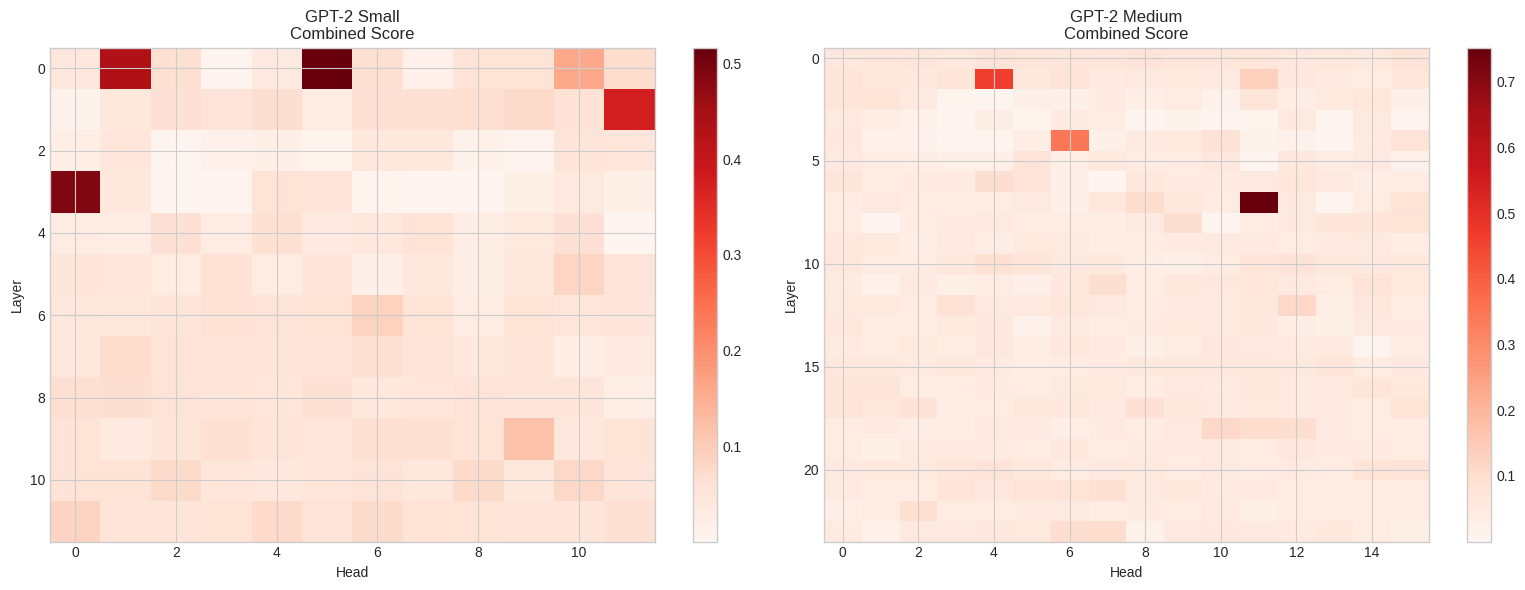

In [ ]:
# Initialize comparator
comparator = ModelComparator()

# Compare induction heads across GPT-2 Small and GPT-2 Medium
example = example_manager.get_example("abab_pattern")
comparison = comparator.compare_induction_heads(model_manager, example)

# Plot side-by-side heatmaps
comparator.plot_comparison_heatmaps(comparison)
plt.show()

In [31]:
# Find similar heads across models (normalized by architecture)
similar_heads = comparator.find_similar_heads(comparison, top_n=5)
print("Top induction heads across models (normalized positions):")
similar_heads

Top induction heads across models (normalized positions):


,Model,Layer,Head,Normalized Layer,Normalized Head,Combined Score
0,GPT-2 Small,0,5,0.000000,0.416667,0.516942
1,GPT-2 Small,3,0,0.250000,0.000000,0.489417
2,GPT-2 Small,0,1,0.000000,0.083333,0.432729
3,GPT-2 Small,1,11,0.083333,0.916667,0.374126
4,GPT-2 Small,0,10,0.000000,0.833333,0.158714
5,GPT-2 Medium,7,11,0.291667,0.687500,0.751953
6,GPT-2 Medium,1,4,0.041667,0.250000,0.461243
7,GPT-2 Medium,4,6,0.166667,0.375000,0.344290
8,GPT-2 Medium,1,11,0.041667,0.687500,0.134432
9,GPT-2 Medium,12,12,0.500000,0.750000,0.115082


In [32]:
# Cross-language analysis: are the same heads active across languages?
model = model_manager.get_model("GPT-2 Small").model
cross_lang_results = comparator.cross_language_analysis(
    model, "GPT-2 Small", example_manager
)
print("Induction heads across languages:")
cross_lang_results

Induction heads across languages:


,Language,Example,Layer,Head,Combined Score
0,English,repeat_en,0.0,1.0,0.449335
1,English,repeat_en,3.0,0.0,0.406965
2,English,repeat_en,0.0,5.0,0.398643
3,English,repeat_random,0.0,5.0,0.425166
4,English,repeat_random,0.0,1.0,0.415149
5,English,repeat_random,3.0,0.0,0.328400
6,Spanish,repeat_es,3.0,0.0,0.656917
7,Spanish,repeat_es,0.0,5.0,0.527943
8,Spanish,repeat_es,0.0,1.0,0.449302
9,French,repeat_fr,3.0,0.0,0.594768


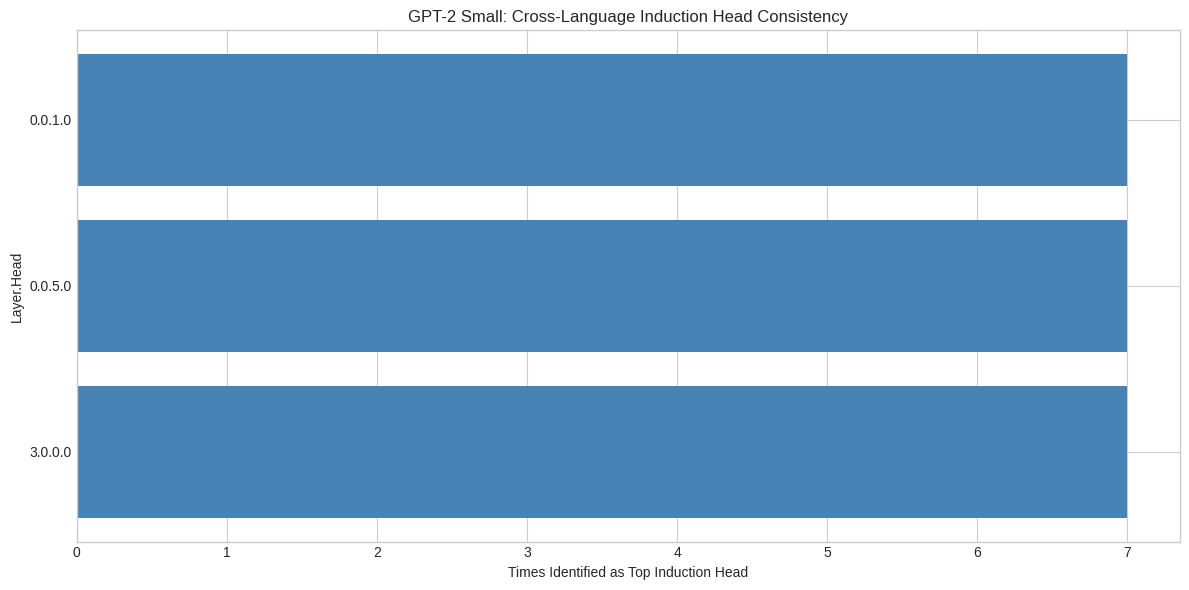

In [33]:
# Plot which heads are consistently identified across languages
comparator.plot_cross_language_consistency(cross_lang_results, "GPT-2 Small")
plt.show()

## 7. Quick Reference: Running Your Own Experiments

### Adding a new model:
```python
model_manager.load_model("gpt2-large", "GPT-2 Large")
```

### Adding a new test example:
```python
example_manager.add_example(
    "my_example",
    "Your repeated text here. Your repeated text here.",
    "English",
    "Description of this example"
)
```

### Detect induction heads:
```python
model = model_manager.get_model("GPT-2 Small").model
scores = detector.detect_induction_heads(model, "Text with repeated patterns")
top_heads = detector.get_top_induction_heads(scores, n=10)
```

### Visual analysis:
```python
logits, cache = visualizer.run_with_cache(model, text)
tokens = model.to_str_tokens(text)
visualizer.plot_layer_heads(cache, tokens, layer=5, n_heads=12)
visualizer.interactive_attention(cache, tokens, layer=5)
```

### Ablation study:
```python
heads_to_ablate = [(5, 1), (5, 5)]  # (layer, head) tuples
_, cache_ablated = ablation.run_with_ablation(model, text, heads_to_ablate)
diff = ablation.compare_activations(cache_original, cache_ablated, model)
ablation.plot_ablation_comparison(cache_original, cache_ablated, tokens, 5, 1, heads_to_ablate)
```

### Cross-model comparison:
```python
comparison = comparator.compare_induction_heads(model_manager, example)
comparator.plot_comparison_heatmaps(comparison)
```

## 8. Scratch Space - Run Your Experiments

In [8]:
model_manager = ModelManager()

model_manager.load_model("gpt2", "GPT-2 Small")
model_manager.load_model("pythia-160m", "Pythia 160M")

# Display architecture comparison
model_manager.compare_architectures()

Loading GPT-2 Small...


`torch_dtype` is deprecated! Use `dtype` instead!
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 91ac5047-06c0-4f53-9652-ebeb914f1121)')' thrown while requesting HEAD https://huggingface.co/gpt2/resolve/main/generation_config.json
Retrying in 1s [Retry 1/5].


Loaded pretrained model gpt2 into HookedTransformer
  Loaded: 12 layers, 12 heads, d_model=768
Loading Pythia 160M...
Loaded pretrained model pythia-160m into HookedTransformer
  Loaded: 12 layers, 12 heads, d_model=768


,Model,Layers,Heads,d_head,d_model,Total Params
0,GPT-2 Small,12,12,64,768,163049041
1,Pythia 160M,12,12,64,768,162334848


In [29]:
# Initialize example manager
example_manager = ExampleManager()
example_manager.add_example("repeat_tag", "Umupo ang pusa sa banig. Umupo ang pusa sa banig.", language="Tagalog", description="Simple repeated sequence in Tagalog.")
example_manager.add_example("repeat_2_en", "We ran from the ghost. We ran from the ghost.", language="English", description="Simple repeated sequence in English.")
example_manager.add_example("repeat_2_es", "Corrimos del fantasma. Corrimos del fantasma.", language="Spanish", description="Simple repeated sequence in Spanish.")
example_manager.add_example("repeat_2_tag", "Tumakbo kami mula sa multo. Tumakbo kami mula sa multo.", language="Tagalog", description="Simple repeated sequence in Tagalog.")
example_manager.list_examples()

,Key,Language,Description,Text Preview
0,repeat_en,English,Simple repeated sentence - classic induction test,The cat sat on the mat. The cat sat on the mat.
1,repeat_random,English,Repeated token sequence with rare tokens,Alpha Beta Gamma Delta Alpha Beta Gamma Delta ...
2,repeat_es,Spanish,Spanish repeated sentence,El gato negro corre rápido. El gato negro corr...
3,repeat_fr,French,French repeated sentence,Le chat dort sur le lit. Le chat dort sur le lit.
4,repeat_de,German,German repeated sentence,Der Hund läuft im Park. Der Hund läuft im Park.
5,repeat_zh,Chinese,Chinese repeated sentence,我喜欢吃苹果和香蕉。我喜欢吃苹果和香蕉。
6,repeat_ja,Japanese,Japanese repeated sentence,今日は天気がいいです。今日は天気がいいです。
7,repeat_code,Code,Repeated code pattern,def foo(): return bar\ndef foo(): return bar
8,abab_pattern,Pattern,Pure ABAB repetition pattern (spaces help toke...,A B C D E F G H A B C D E F G H A B
9,random_repeat,Random,Random token sequences repeated,xq7 mn2 pz9 ab3 xq7 mn2 pz9 ab3 xq7


In [118]:
detector = InductionHeadDetector()
visualizer = AttentionVisualizer()
ablation = AblationFramework()
comparator = ModelComparator()

In [64]:
def compare_dfs(df1, df2, df3):
    # Compute how many/which indexes occur in all three dataframes
    set1 = set(zip(df1['Layer'], df1['Head']))
    set2 = set(zip(df2['Layer'], df2['Head']))
    set3 = set(zip(df3['Layer'], df3['Head']))
    common = set1 & set2 & set3
    return common

In [99]:
model = model_manager.get_model("GPT-2 Small").model
example_1 = example_manager.get_example("repeat_2_en")
example_2 = example_manager.get_example("repeat_2_es")
example_3 = example_manager.get_example("repeat_2_tag")

scores_1 = detector.detect_induction_heads(model, example_1.text)
scores_2 = detector.detect_induction_heads(model, example_2.text)
scores_3 = detector.detect_induction_heads(model, example_3.text)

print("Top 10 Induction Head Candidates for English:")
detected_1 = detector.get_top_induction_heads(scores_1, n=10)
print(detected_1)
print("Top 10 Induction Head Candidates for Spanish:")
detected_2 = detector.get_top_induction_heads(scores_2, n=10)
print(detected_2)
print("Top 10 Induction Head Candidates for Tagalog:")
detected_3 = detector.get_top_induction_heads(scores_3, n=10)
print(detected_3)

print("Common Induction Heads Across Languages:")
common_heads = compare_dfs(detected_1, detected_2, detected_3)
print(common_heads)

Top 10 Induction Head Candidates for English:
     Layer  Head  Induction Score  Prefix Match Score  Combined Score
1        0     1         0.433609            0.502095        0.467852
5        0     5         0.447624            0.431894        0.439759
23       1    11         0.415141            0.381942        0.398542
36       3     0         0.407447            0.217956        0.312702
55       4     7         0.212228            0.226018        0.219123
140     11     8         0.186344            0.247603        0.216973
10       0    10         0.235487            0.184398        0.209943
17       1     5         0.207082            0.132972        0.170027
132     11     0         0.144640            0.162706        0.153673
70       5    10         0.150377            0.119088        0.134733
Top 10 Induction Head Candidates for Spanish:
     Layer  Head  Induction Score  Prefix Match Score  Combined Score
36       3     0         0.636956            0.530896        0.58392

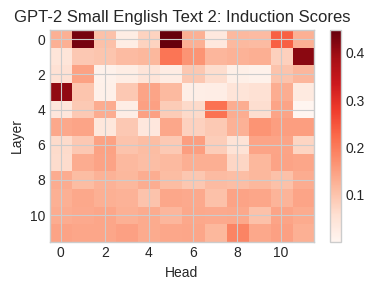

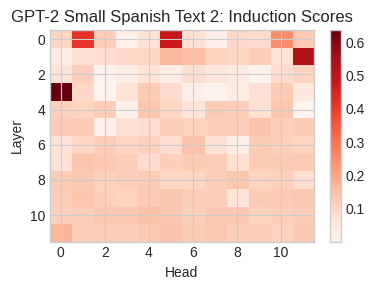

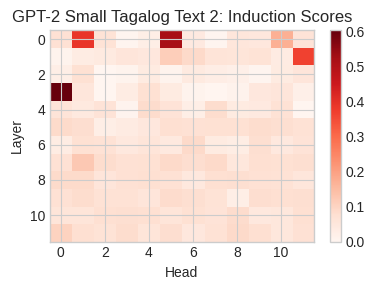

In [100]:
detector.plot_induction_scores(scores_1, "GPT-2 Small English Text 2", figsize=(4, 3))
plt.show()
detector.plot_induction_scores(scores_2, "GPT-2 Small Spanish Text 2", figsize=(4, 3))
plt.show()
detector.plot_induction_scores(scores_3, "GPT-2 Small Tagalog Text 2", figsize=(4, 3))
plt.show()

In [101]:
model = model_manager.get_model("Pythia 160M").model
example_1 = example_manager.get_example("repeat_2_en")
example_2 = example_manager.get_example("repeat_2_es")
example_3 = example_manager.get_example("repeat_2_tag")

scores_1 = detector.detect_induction_heads(model, example_1.text)
scores_2 = detector.detect_induction_heads(model, example_2.text)
scores_3 = detector.detect_induction_heads(model, example_3.text)

print("Top 10 Induction Head Candidates for English:")
detected_1 = detector.get_top_induction_heads(scores_1, n=10)
print(detected_1)
print("Top 10 Induction Head Candidates for Spanish:")
detected_2 = detector.get_top_induction_heads(scores_2, n=10)
print(detected_2)
print("Top 10 Induction Head Candidates for Tagalog:")
detected_3 = detector.get_top_induction_heads(scores_3, n=10)
print(detected_3)

print("Common Induction Heads Across Languages:")
common_heads = compare_dfs(detected_1, detected_2, detected_3)
print(common_heads)

Top 10 Induction Head Candidates for English:
     Layer  Head  Induction Score  Prefix Match Score  Combined Score
39       3     3         0.538168            0.640583        0.589375
18       1     6         0.556453            0.484710        0.520582
7        0     7         0.380790            0.303047        0.341919
65       5     5         0.244384            0.327101        0.285743
2        0     2         0.188763            0.299997        0.244380
15       1     3         0.267255            0.208654        0.237954
138     11     6         0.225678            0.250157        0.237918
135     11     3         0.201911            0.249735        0.225823
134     11     2         0.195497            0.243130        0.219313
105      8     9         0.169654            0.243730        0.206692
Top 10 Induction Head Candidates for Spanish:
     Layer  Head  Induction Score  Prefix Match Score  Combined Score
18       1     6         0.601645            0.556233        0.57893

In [50]:
logits, cache = visualizer.run_with_cache(model, example_2.text)
tokens = model.to_str_tokens(example_2.text)

In [47]:
visualizer.interactive_attention(cache, tokens, layer=3)

In [ ]:
visualizer.plot_layer_heads(cache, tokens, layer=5, n_heads=12)

Hypothesis 4: Ablation: zeroing out previous tokens heads should break the induction head.

Top 10 Induction Head Candidates for English:
     Layer  Head  Induction Score  Prefix Match Score  Combined Score
1        0     1         0.418061            0.480610        0.449335
36       3     0         0.476302            0.337627        0.406965
5        0     5         0.388184            0.409102        0.398643
23       1    11         0.395005            0.398903        0.396954
10       0    10         0.205053            0.162254        0.183653
140     11     8         0.160305            0.199913        0.180109
55       4     7         0.168135            0.191907        0.180021
17       1     5         0.181871            0.133074        0.157473
132     11     0         0.133188            0.127332        0.130260
135     11     3         0.151841            0.098254        0.125047

Ablating heads: [(0, 1), (3, 0), (0, 5), (1, 11), (0, 10)]
Heads most affected by ablation:
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.     

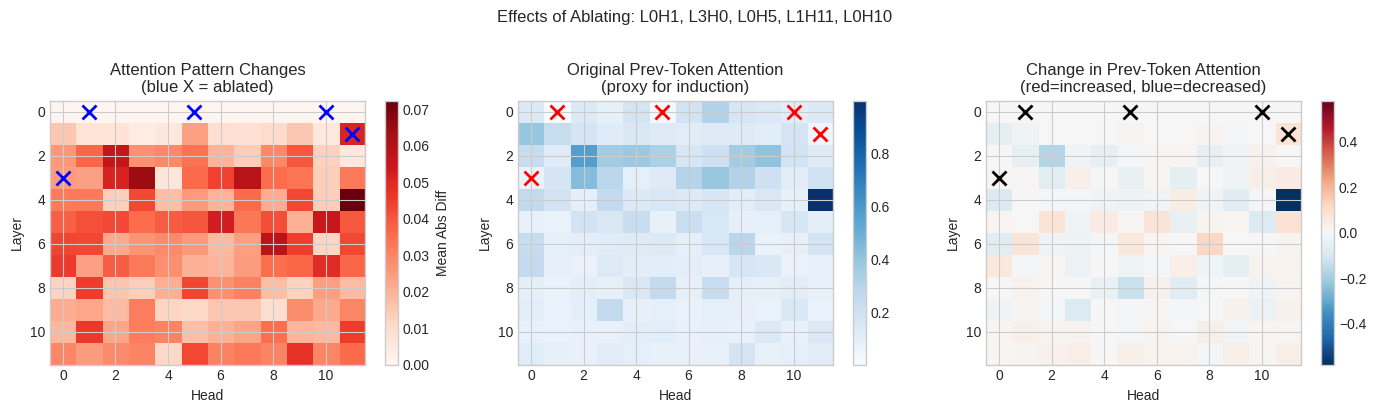

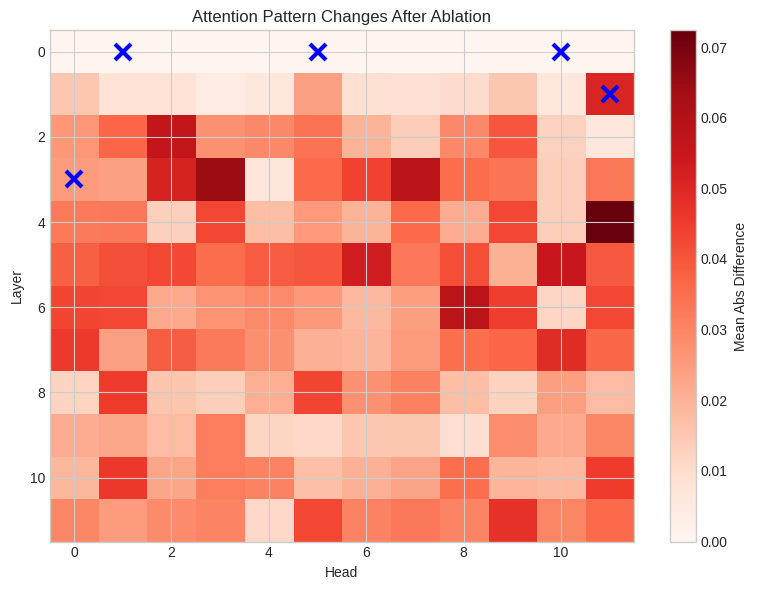

In [119]:
model = model_manager.get_model("GPT-2 Small").model
example_1 = example_manager.get_example("repeat_en")

scores_1 = detector.detect_induction_heads(model, example_1.text)

print("Top 10 Induction Head Candidates for English:")
detected_1 = detector.get_top_induction_heads(scores_1, n=10)
print(detected_1)

# example_1 = example_manager.get_example("repeat_en")
# example_2 = example_manager.get_example("repeat_es")
# example_3 = example_manager.get_example("repeat_tag")

# scores_1 = detector.detect_induction_heads(model, example_1.text)
# scores_2 = detector.detect_induction_heads(model, example_2.text)
# scores_3 = detector.detect_induction_heads(model, example_3.text)

# print("Top 10 Induction Head Candidates for English:")
# detected_1 = detector.get_top_induction_heads(scores_1, n=10)
# print(detected_1)
# print("Top 10 Induction Head Candidates for Spanish:")
# detected_2 = detector.get_top_induction_heads(scores_2, n=10)
# print(detected_2)
# print("Top 10 Induction Head Candidates for Tagalog:")
# detected_3 = detector.get_top_induction_heads(scores_3, n=10)
# print(detected_3)

# Select heads to ablate (top 3)
heads_to_ablate = [(int(row['Layer']), int(row['Head'])) for _, row in detected_1.head(5).iterrows()]
print(f"\nAblating heads: {heads_to_ablate}")

# Run model with and without ablation
tokens = model.to_tokens(example_1.text)
str_tokens = model.to_str_tokens(example_1.text)

# Original run
_, cache_original = model.run_with_cache(tokens)

# Ablated run
_, cache_ablated = ablation.run_with_ablation(model, example_1.text, heads_to_ablate)

# Compare activations - which heads changed the most?
df, diff_df = ablation.compare_activations(cache_original, cache_ablated, model)
print("Heads most affected by ablation:")
print(diff_df)

# Visualize how a specific head's attention pattern changed after ablation
# Pick one of the ablated heads to inspect
target_layer, target_head = heads_to_ablate[0]
ablation.plot_ablation_comparison(
    cache_original, cache_ablated, model, heads_to_ablate, figsize=(14, 4))
plt.show()

ablation.plot_ablation_heatmap(
    diff_matrix=diff_df,
    ablated_heads=heads_to_ablate,
    title="Attention Pattern Changes After Ablation",
    figsize=(8, 6)
)
plt.show()

In [120]:
result = ablation.compare_generation(
    model, " A B C D E F G H A B C D E F G H A B", heads_to_ablate, max_new_tokens=30, temperature=0.0, verbose=True
)

GENERATION COMPARISON (Ablating: L0H1, L3H0, L0H5, L1H11, L0H10)

Prompt:  A B C D E F G H A B C D E F G H A B

──────────────────────────────────────────────────────────────────────
NORMAL GENERATION:
  <|endoftext|> A B C D E F G H A B C D E F G H A B C D E F G H A B C D E F G H A B C D E F G H A B C D E F G H

──────────────────────────────────────────────────────────────────────
ABLATED GENERATION:
  <|endoftext|> A B C D E F G H A B C D E F G H A B A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A

──────────────────────────────────────────────────────────────────────
TOKEN-BY-TOKEN COMPARISON (generated tokens only):
 Position Normal Ablated  Match
       19      C       A  False
       20      D       A  False
       21      E       A  False
       22      F       A  False
       23      G       A  False
       24      H       A  False
       25      A       A   True
       26      B       A  False
       27      C       A  False
       28      D       A  False
       

GENERATION ATTENTION COMPARISON (Ablating: L0H1, L3H0, L0H5, L1H11, L0H10)

Normal:  <|endoftext|> A B C D E F G H A B C D E F G H A B C D E F G H A B C D E F G H A B C D E F
Ablated: <|endoftext|> A B C D E F G H A B C D E F G H A B A A A A A A A A A A A A A A A A A A A A


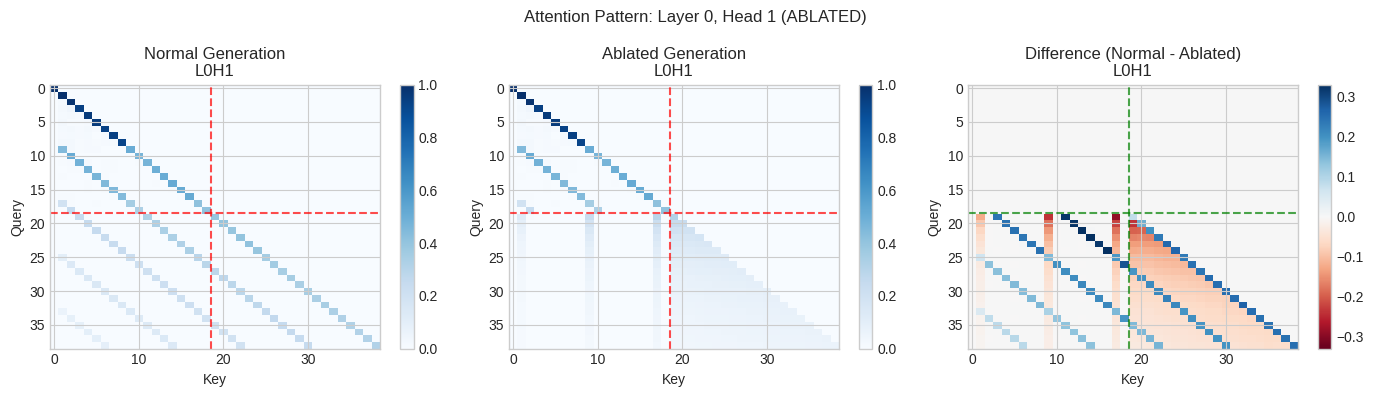

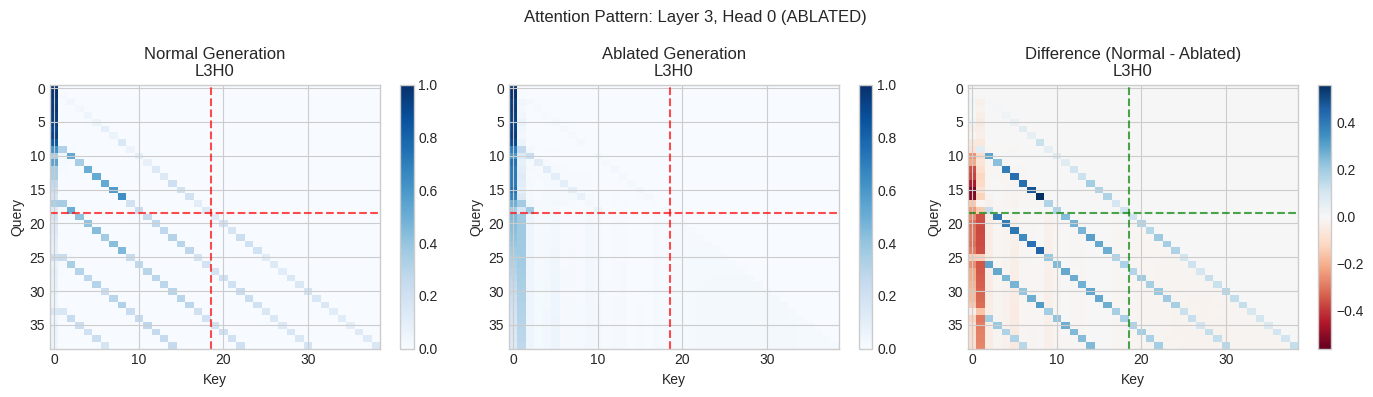

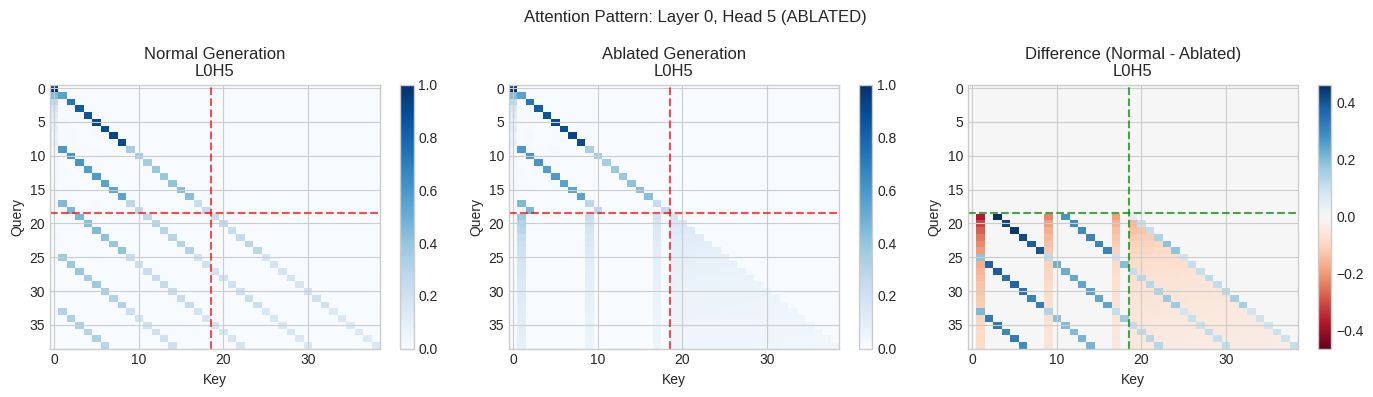

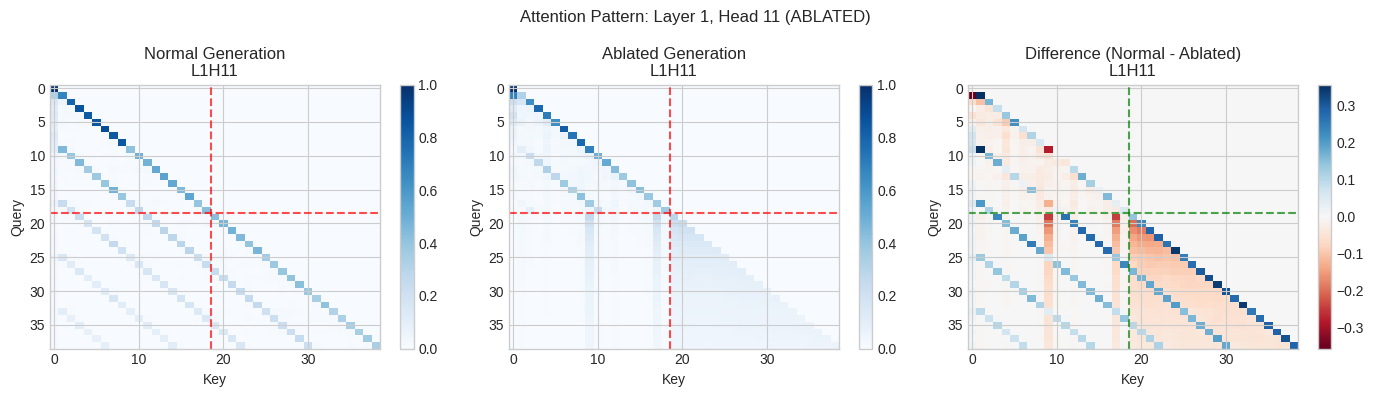

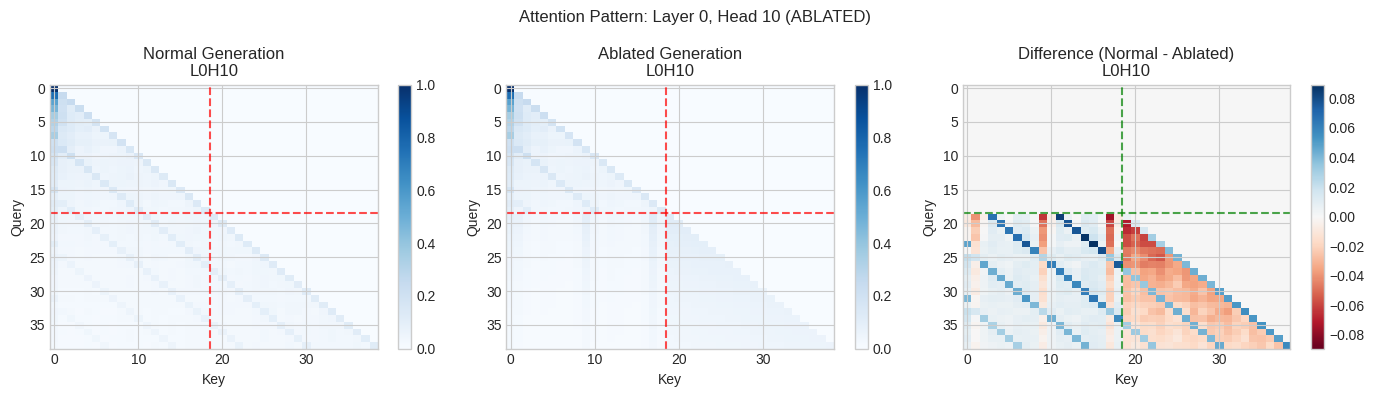

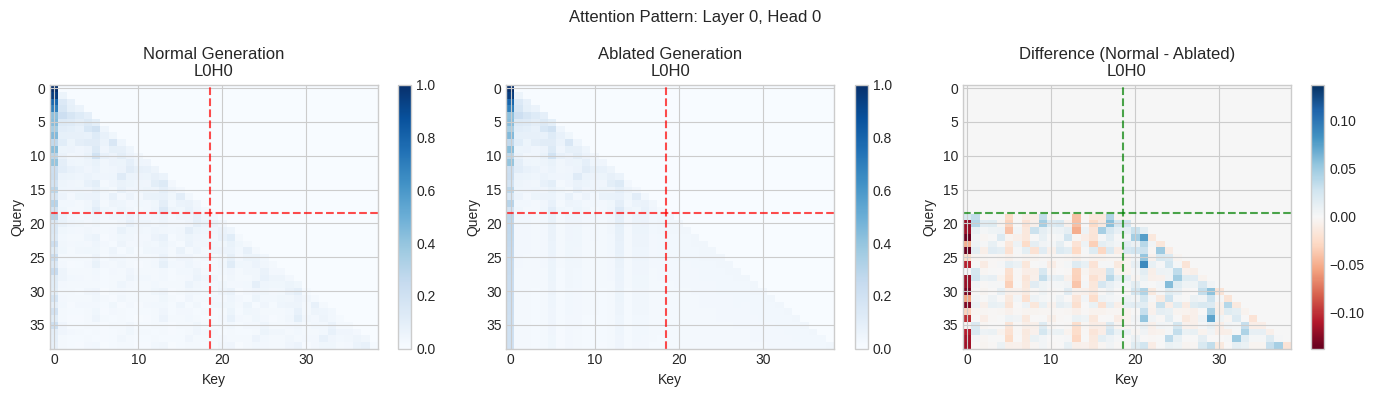

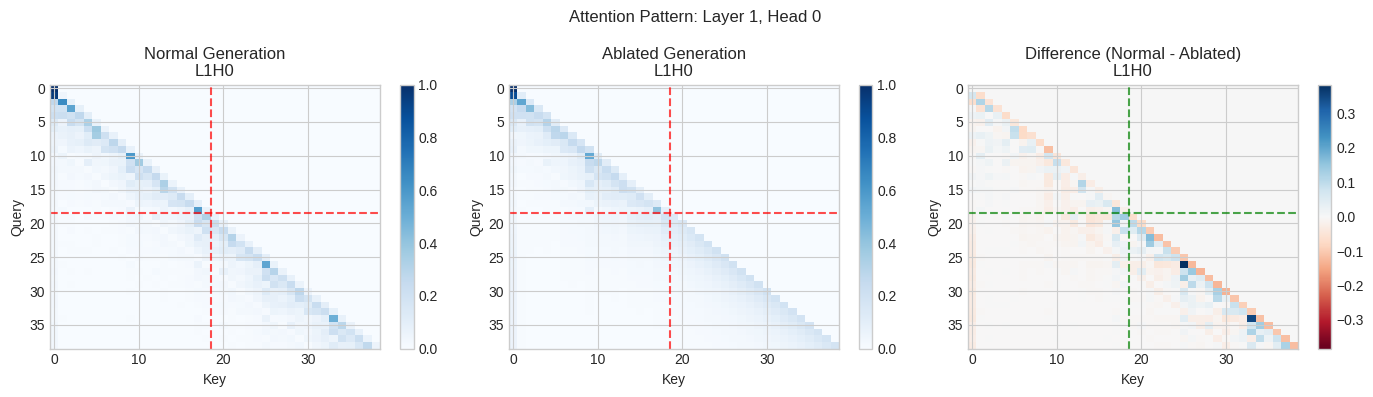

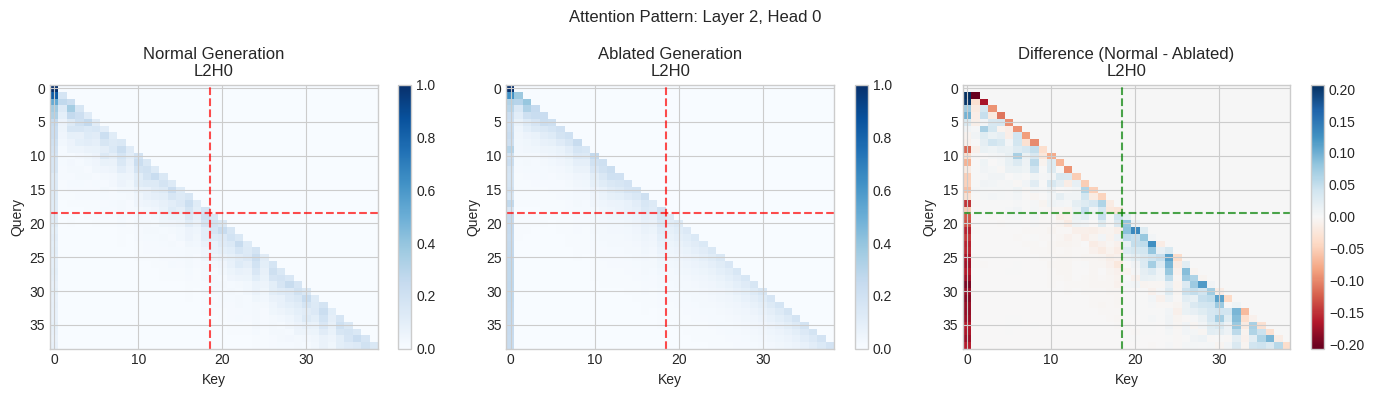

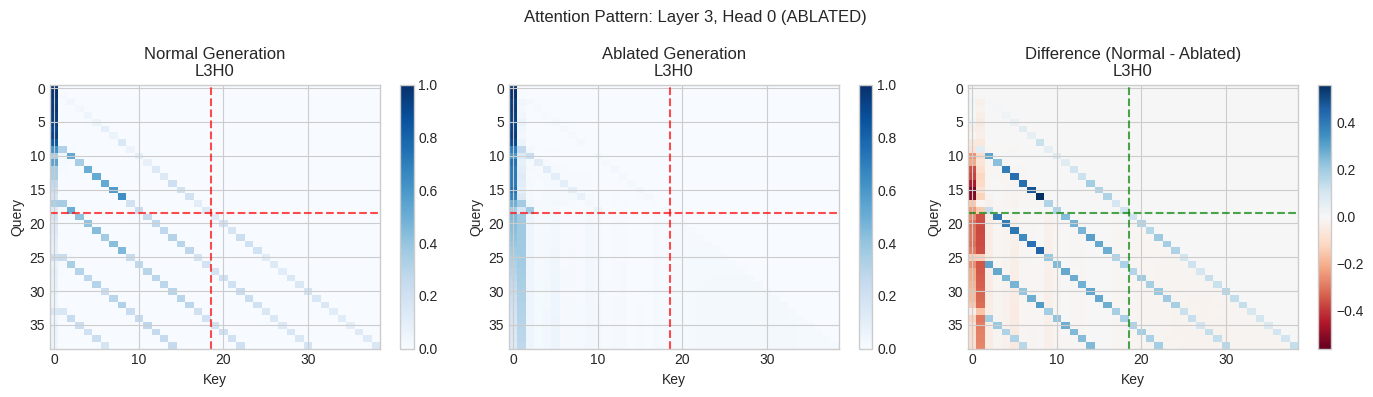

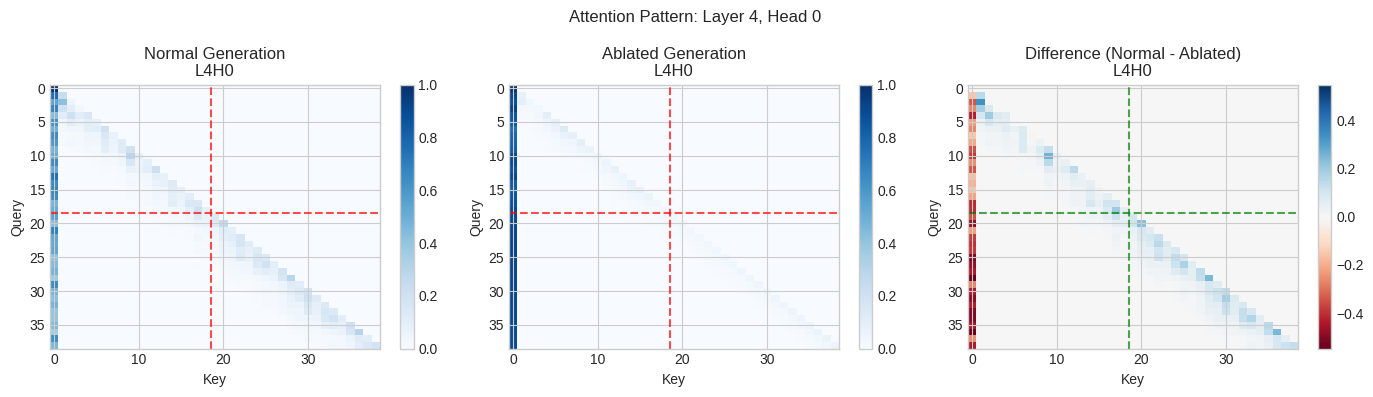

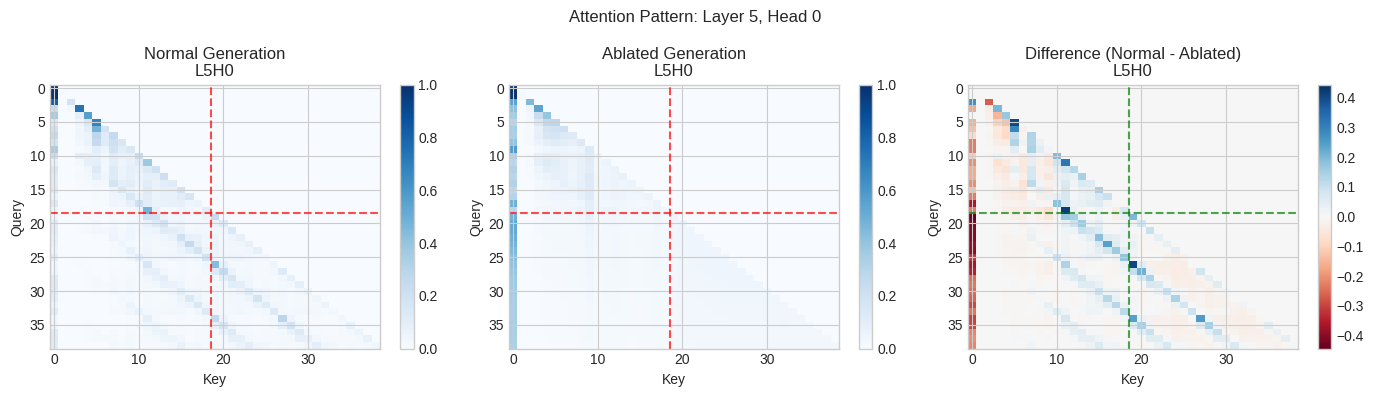

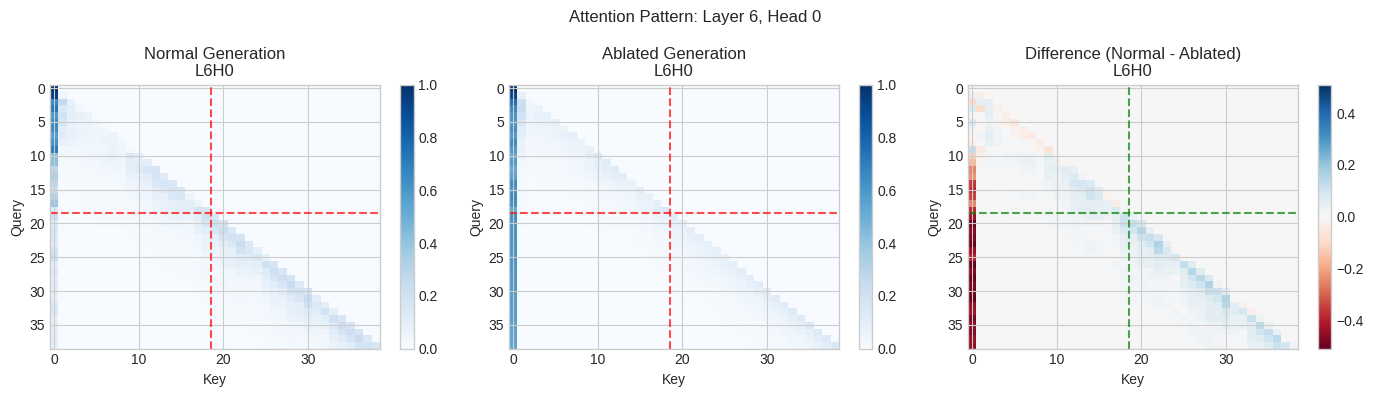

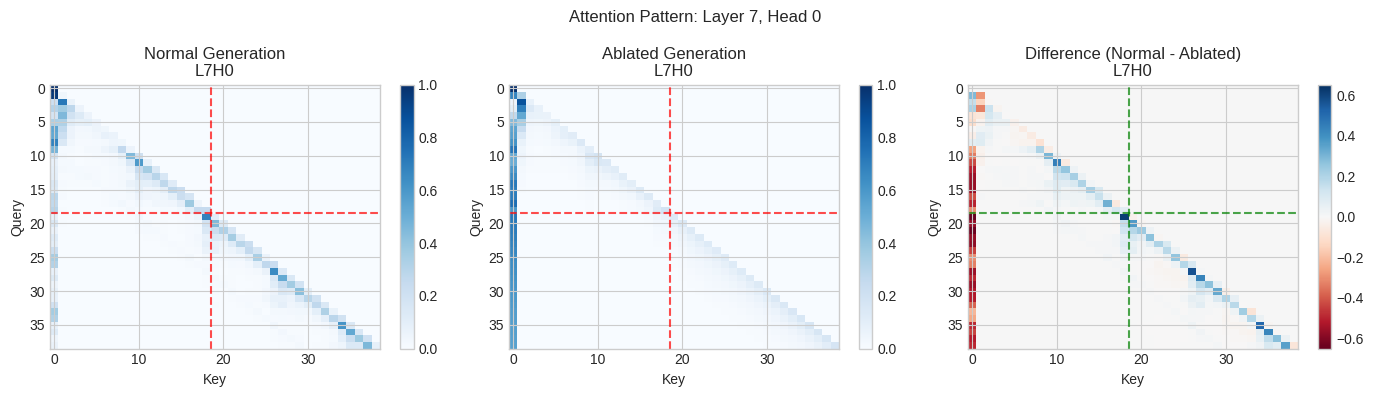

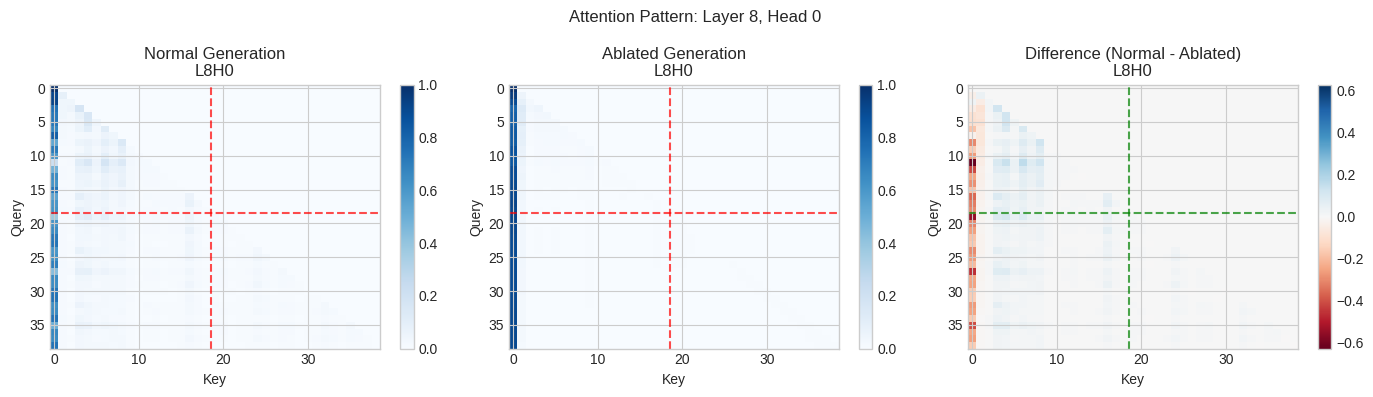

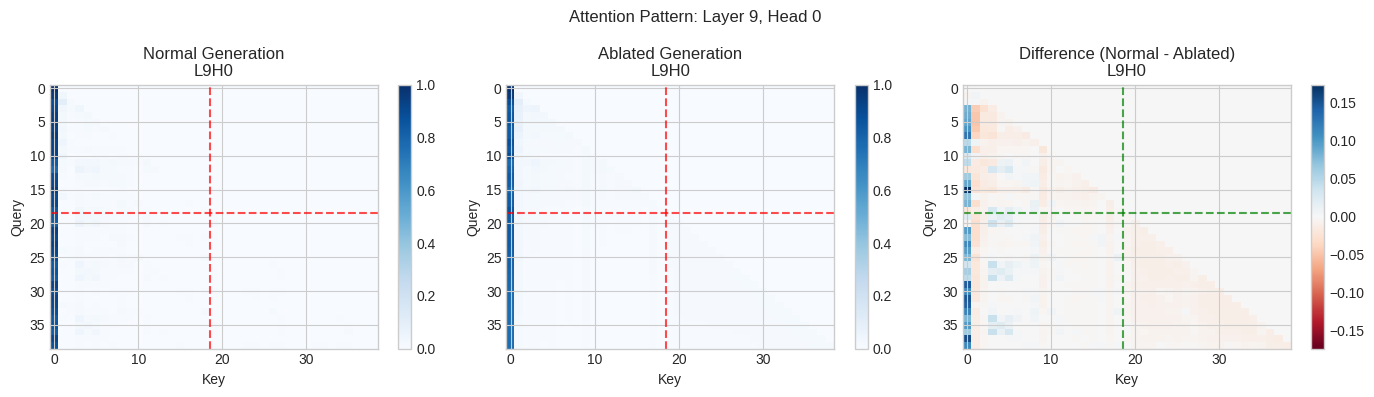

In [123]:
result = ablation.compare_generation_attention(
    model, " A B C D E F G H A B C D E F G H A B", heads_to_ablate, heads_to_visualize=heads_to_ablate + [(0, 0),(1, 0),(2, 0),(3, 0),(4, 0),(5, 0),(6, 0),(7, 0),(8, 0),(9, 0)], max_new_tokens=20, temperature=0.0, figsize=(14, 4)
)
for fig in result['figures']:
    plt.show(fig)